In [17]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

from IPython.display import display


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

# -----------------------
# Load processed data
# -----------------------

df = pd.read_csv("data/sales_cleaned.csv") # sales

# -----------------------
# Features for clustering
# (NO churn label)
# -----------------------
numeric_features = [
    "annual_contract_value",
    "discount_pct",
    "initial_onboarding_score"
]

categorical_features = [
    "company_size_bucket",
    "product_tier",
    "sales_segment",
    "acquisition_channel" #TODO: industry
]

X_cluster = df[numeric_features + categorical_features]

# -----------------------
# Preprocessing
# -----------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [18]:
# ==========================================================
# Task 2 HIERARCHICAL CLUSTERING (VALIDATION)
# ==========================================================

from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# -----------------------
# Select numeric features only
# -----------------------
numeric_features = [
    "annual_contract_value",
    "discount_pct",
    "initial_onboarding_score"
]

X_hier = df[numeric_features]

# -----------------------
# Impute + scale
# -----------------------
X_hier = SimpleImputer(strategy="median").fit_transform(X_hier)
X_hier = StandardScaler().fit_transform(X_hier)

# -----------------------
# Hierarchical clustering
# -----------------------
Z = linkage(X_hier, method="ward")

# Cut dendrogram into 4 clusters (for comparison)
cut = 4
df["hier_cluster"] = fcluster(Z, t=cut, criterion="maxclust")

# -----------------------
# Churn concentration by hierarchical cluster
# -----------------------
hier_summary = (
    df
    .groupby("hier_cluster")
    .agg(
        customers=("customer_id", "count"),
        churn_count=("is_churned", "sum"),
        churn_rate=("is_churned", "mean"),
        avg_acv=("annual_contract_value", "mean"),
        avg_discount=("discount_pct", "mean"),
        avg_onboarding=("initial_onboarding_score", "mean")
    )
)

hier_summary["churn_share"] = (
    hier_summary["churn_count"] / hier_summary["churn_count"].sum()
)


hier_summary = hier_summary[
    [
        "customers",
        "churn_count",
        "churn_rate",
        "churn_share",
        "avg_acv",
        "avg_discount",
        "avg_onboarding"
    ]
].sort_values("churn_share", ascending=False)

# Re-label clusters as 0–3 based on ranking
hier_summary["ranked_cluster"] = range(1,len(hier_summary) + 1)

# Move ranked_cluster to index
hier_summary = hier_summary.set_index("ranked_cluster")

print("\n=== Hierarchical Clustering — Churn Concentration ===")
display(hier_summary)



=== Hierarchical Clustering — Churn Concentration ===


,customers,churn_count,churn_rate,churn_share,avg_acv,avg_discount,avg_onboarding
ranked_cluster,,,,,,,
1,1200,172,0.143333,0.472527,24513.294292,0.308875,5.693250
2,947,119,0.125660,0.326923,27008.081658,0.110781,5.664942
3,729,69,0.094650,0.189560,10554.806406,0.133676,7.963237
4,124,4,0.032258,0.010989,364083.102742,0.181129,6.449194



=== 80/20 Lost Revenue by Hierarchical Cluster ===
   hier_cluster  customers  churned  lost_revenue        avg_acv  loss_share  \
1             2       1200      172    2304843.93   24513.294292    0.441113   
0             1        124        4    1490347.12  364083.102742    0.285230   
3             4        947      119    1169070.70   27008.081658    0.223743   
2             3        729       69     260804.99   10554.806406    0.049914   

   cum_loss_share  
1        0.441113  
0        0.726343  
3        0.950086  
2        1.000000  


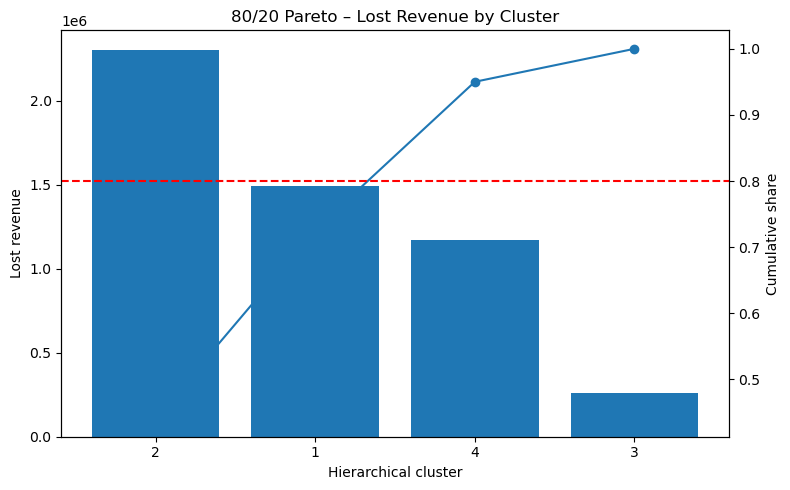

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Lost revenue definition
df["lost_revenue"] = df["annual_contract_value"] * df["is_churned"]

# Aggregate by hierarchical cluster
rev_8020 = (
    df.groupby("hier_cluster")
      .agg(
          customers=("customer_id", "count"),
          churned=("is_churned", "sum"),
          lost_revenue=("lost_revenue", "sum"),
          avg_acv=("annual_contract_value", "mean")
      )
      .reset_index()
)

# Sort by lost revenue (descending)
rev_8020 = rev_8020.sort_values("lost_revenue", ascending=False)

# Cumulative share
total_loss = rev_8020["lost_revenue"].sum()
rev_8020["loss_share"] = rev_8020["lost_revenue"] / total_loss
rev_8020["cum_loss_share"] = rev_8020["loss_share"].cumsum()

print("\n=== 80/20 Lost Revenue by Hierarchical Cluster ===")
print(rev_8020)

# Plot
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.bar(
    rev_8020["hier_cluster"].astype(str),
    rev_8020["lost_revenue"]
)
ax1.set_ylabel("Lost revenue")

ax2 = ax1.twinx()
ax2.plot(
    rev_8020["hier_cluster"].astype(str),
    rev_8020["cum_loss_share"],
    marker="o"
)
ax2.axhline(0.8, linestyle="--", color="red")
ax2.set_ylabel("Cumulative share")

ax1.set_xlabel("Hierarchical cluster")
ax1.set_title("80/20 Pareto – Lost Revenue by Cluster")

plt.tight_layout()
plt.show()

#### Churn Spike BEFORE & AFTER

## Aggregate tickets information

In [20]:
# join df with cluster assignment to get prototype_cluster
cluster = pd.read_csv("data/customer_cluster_assignments.csv")
cluster.head()

,customer_id,kmeans_cluster,hierarchical_cluster,kprototype_cluster
0,C100000,2,3,1
1,C100001,1,4,0
2,C100002,0,2,2
3,C100003,1,3,1
4,C100004,1,4,0


In [21]:
df = df.merge(cluster, on='customer_id')
print(len(df))
df.head()

3000


,Unnamed: 0,customer_id,company_name,country,region,is_eu,industry,company_size_bucket,annual_contract_value,product_tier,sales_segment,acquisition_channel,contract_start_date,contract_end_date,renewed_flag,discount_pct,initial_onboarding_score,is_churned,hier_cluster,lost_revenue,kmeans_cluster,hierarchical_cluster,kprototype_cluster
0,0,C100000,Company_0,Canada,North America,0,Healthcare,51-200,12999.25,Growth,MidMarket,Partner,2023-05-02,NaN,1,0.03,7.0,0,3,0.00,2,3,1
1,1,C100001,Company_1,UK,Europe,1,Wholesale,1-10,1799.72,Starter,SMB_Field,Inbound,2023-02-18,NaN,1,0.15,4.9,0,4,0.00,1,4,0
2,2,C100002,Company_2,US,North America,0,Manufacturing,1-10,1770.83,Starter,SMB_Field,Inbound,2023-11-12,2024-05-13,0,0.37,4.8,1,2,1770.83,0,2,2
3,3,C100003,Company_3,France,Europe,1,Missing,1-10,1790.30,Starter,SMB_Field,Outbound,2023-08-06,NaN,1,0.10,8.0,0,3,0.00,1,3,1
4,4,C100004,Company_4,Netherlands,Europe,1,Professional Services,1-10,1552.00,Starter,SMB_Inside,Inbound,2023-09-09,2024-03-10,0,0.11,3.8,1,4,1552.00,1,4,0


In [22]:
tickets = pd.read_csv("data/tickets_aggregated.csv")

# drop junk index col if present
tickets = tickets.drop(columns=["Unnamed: 0"], errors="ignore")

# key consistency
tickets["customer_id"] = tickets["customer_id"].astype(str)
df["customer_id"] = df["customer_id"].astype(str)

# merge
df_tickets = df.merge(tickets, on="customer_id", how="left")

In [43]:
df_tickets.head()

,Unnamed: 0,customer_id,company_name,country,region,is_eu,industry,company_size_bucket,annual_contract_value,product_tier,sales_segment,acquisition_channel,contract_start_date,contract_end_date,renewed_flag,discount_pct,initial_onboarding_score,is_churned,hier_cluster,lost_revenue,kmeans_cluster,hierarchical_cluster,kprototype_cluster,Q3_Status,channel,priority,issue_category,ticket_text,avg_sentiment,avg_first_response_hours,avg_resolution_hours,avg_resolved,ticket_count
0,0,C100000,Company_0,Canada,North America,0,Healthcare,51-200,12999.25,Growth,MidMarket,Partner,2023-05-02,NaN,1,0.03,7.0,0,3,0.00,2,3,1,Before Q3,Chat,Medium,product_performance,Dashboard loads very slowly during peak hours.,0.44,0.11,14.88,1.0,1.0
1,1,C100001,Company_1,UK,Europe,1,Wholesale,1-10,1799.72,Starter,SMB_Field,Inbound,2023-02-18,NaN,1,0.15,4.9,0,4,0.00,1,4,0,Before Q3,Email,Low,product_performance,Dashboard loads very slowly during peak hours.,-0.50,8.12,9.37,1.0,1.0
2,2,C100002,Company_2,US,North America,0,Manufacturing,1-10,1770.83,Starter,SMB_Field,Inbound,2023-11-12,2024-05-13,0,0.37,4.8,1,2,1770.83,0,2,2,During/After Q3,Email,Medium,product_usability,The new dashboard is confusing for my staff.,-0.50,2.97,31.65,1.0,1.0
3,3,C100003,Company_3,France,Europe,1,Missing,1-10,1790.30,Starter,SMB_Field,Outbound,2023-08-06,NaN,1,0.10,8.0,0,3,0.00,1,3,1,During/After Q3,Phone,High,billing_admin,I need to change our billing email and can't find the option.,-0.11,0.10,12.49,1.0,1.0
4,4,C100004,Company_4,Netherlands,Europe,1,Professional Services,1-10,1552.00,Starter,SMB_Inside,Inbound,2023-09-09,2024-03-10,0,0.11,3.8,1,4,1552.00,1,4,0,During/After Q3,Phone,Medium,product_performance,Inventory sync takes too long to complete.,0.20,5.19,35.67,1.0,1.0


In [44]:
df_tickets.to_csv("data/df_tickets.csv")


=== Within-cluster: churned vs retained ticket behavior ===
   kprototype_cluster  is_churned  customers  lost_revenue  avg_tickets  \
0                   0           0       1899          0.00     0.901001   
1                   0           1        281    1565433.81     0.843416   
2                   1           0       2590          0.00     0.932819   
3                   1           1        178    3419166.77     0.893258   
4                   2           0       1390          0.00     0.944604   
5                   2           1        210    2930958.59     0.880952   
6                   3           0        407          0.00     0.958231   
7                   3           1         18    5665386.13     1.000000   

   avg_sentiment  avg_first_response_hours  avg_resolution_hours  \
0      -0.033755                  3.380361             10.640232   
1      -0.055801                  3.328043              9.954555   
2      -0.039875                  3.541317             11.2

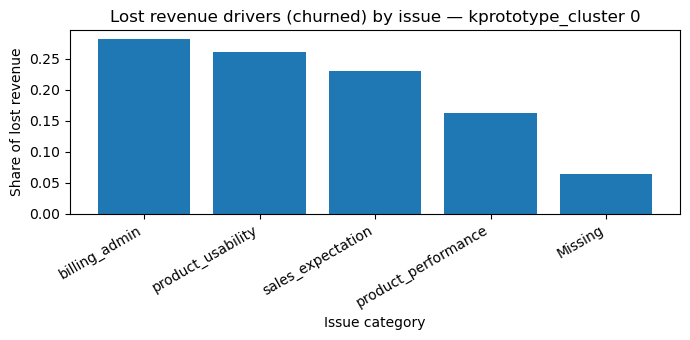

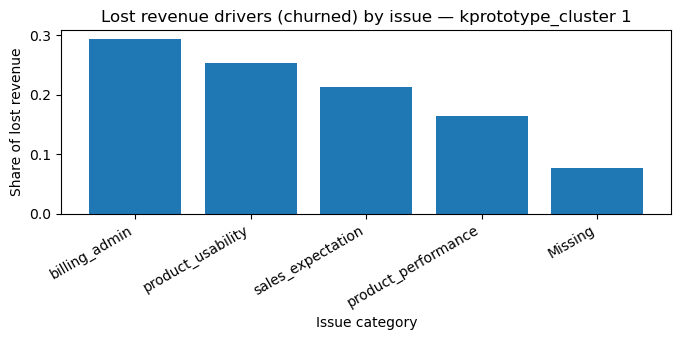

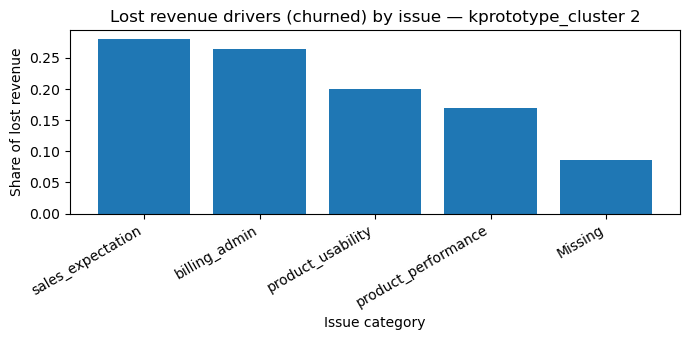

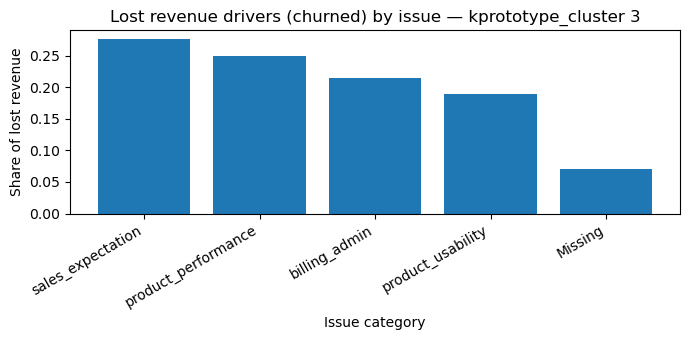

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# tickets = pd.read_csv("data/tickets_aggregated.csv")

# # drop junk index col if present
# tickets = tickets.drop(columns=["Unnamed: 0"], errors="ignore")

# # key consistency
# tickets["customer_id"] = tickets["customer_id"].astype(str)
# df["customer_id"] = df["customer_id"].astype(str)

# # merge
# df_tickets = df.merge(tickets, on="customer_id", how="left")

# fill missing ticket info for customers w/ no tickets
fill_cols = [
    "avg_sentiment",
    "avg_first_response_hours",
    "avg_resolution_hours",
    "avg_resolved",
    "ticket_count",
]
for c in fill_cols:
    if c in df_tickets.columns:
        df_tickets[c] = pd.to_numeric(df_tickets[c], errors="coerce").fillna(0)

# fill categorical ticket fields
for c in ["Q3_Status", "channel", "priority", "issue_category", "ticket_text"]:
    if c in df_tickets.columns:
        df_tickets[c] = df_tickets[c].fillna("Missing").astype(str)

# 1) Pick priority clusters
priority_clusters = [0,1,2,3]
df_priority = df_tickets[df_tickets["kprototype_cluster"].isin(priority_clusters)].copy()

# 2) Cluster-level ticket + churn summary (numbers)
ticket_cluster_summary = (
    df_priority
    .groupby(["kprototype_cluster", "Q3_Status"])
    .agg(
        customers=("customer_id", "count"),
        churned=("is_churned", "sum"),
        churn_rate=("is_churned", "mean"),
        lost_revenue=("lost_revenue", "sum"),
        avg_acv=("annual_contract_value", "mean"),
        avg_tickets=("ticket_count", "mean"),
        avg_sentiment=("avg_sentiment", "mean"),
        avg_first_response_hours=("avg_first_response_hours", "mean"),
        avg_resolution_hours=("avg_resolution_hours", "mean"),
        resolved_rate=("avg_resolved", "mean"),
    )
    .reset_index()
    .sort_values("lost_revenue", ascending=False)
)

# 3) Within each cluster: churned vs retained differences
ticket_churn_compare = (
    df_priority
    .groupby(["kprototype_cluster", "is_churned"])
    .agg(
        customers=("customer_id", "count"),
        lost_revenue=("lost_revenue", "sum"),
        avg_tickets=("ticket_count", "mean"),
        avg_sentiment=("avg_sentiment", "mean"),
        avg_first_response_hours=("avg_first_response_hours", "mean"),
        avg_resolution_hours=("avg_resolution_hours", "mean"),
        resolved_rate=("avg_resolved", "mean"),
    )
    .reset_index()
    .sort_values(["kprototype_cluster", "is_churned"])
)

print("\n=== Within-cluster: churned vs retained ticket behavior ===")
print(ticket_churn_compare)


# 4) Top issue_category among churned customers per cluster
churned_only = df_priority[df_priority["is_churned"] == 1].copy()

churn_issue = (
    churned_only
    .groupby(["kprototype_cluster", "issue_category"])["lost_revenue"]
    .sum()
    .reset_index(name="lost_revenue")
)

churn_issue["cluster_lost_total"] = churn_issue.groupby("kprototype_cluster")["lost_revenue"].transform("sum")
churn_issue["lost_share"] = np.where(
    churn_issue["cluster_lost_total"] > 0,
    churn_issue["lost_revenue"] / churn_issue["cluster_lost_total"],
    0.0
)

print("\n=== Among churned in each cluster: lost revenue by issue_category ===")
print(churn_issue.sort_values(["kprototype_cluster", "lost_share"], ascending=[True, False]))


topk = 6
for hc in sorted(churned_only["kprototype_cluster"].unique()):
    sub = churn_issue[churn_issue["kprototype_cluster"] == hc].sort_values("lost_share", ascending=False).head(topk)
    fig, ax = plt.subplots(figsize=(7,3.5))
    ax.bar(sub["issue_category"].astype(str), sub["lost_share"])
    ax.set_title(f"Lost revenue drivers (churned) by issue — kprototype_cluster {hc}")
    ax.set_ylabel("Share of lost revenue")
    ax.set_xlabel("Issue category")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


=== Global Lost Revenue by Issue Category ===
        issue_category lost_revenue share_of_loss
4    sales_expectation   $3,475,921         25.6%
1        billing_admin   $3,438,551         25.3%
3    product_usability   $2,936,162         21.6%
2  product_performance   $2,719,161         20.0%
0              Missing   $1,011,150          7.4%


/var/folders/yy/5xmm98ks22ndvhr1myh0x83c0000gn/T/ipykernel_58601/13996203.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


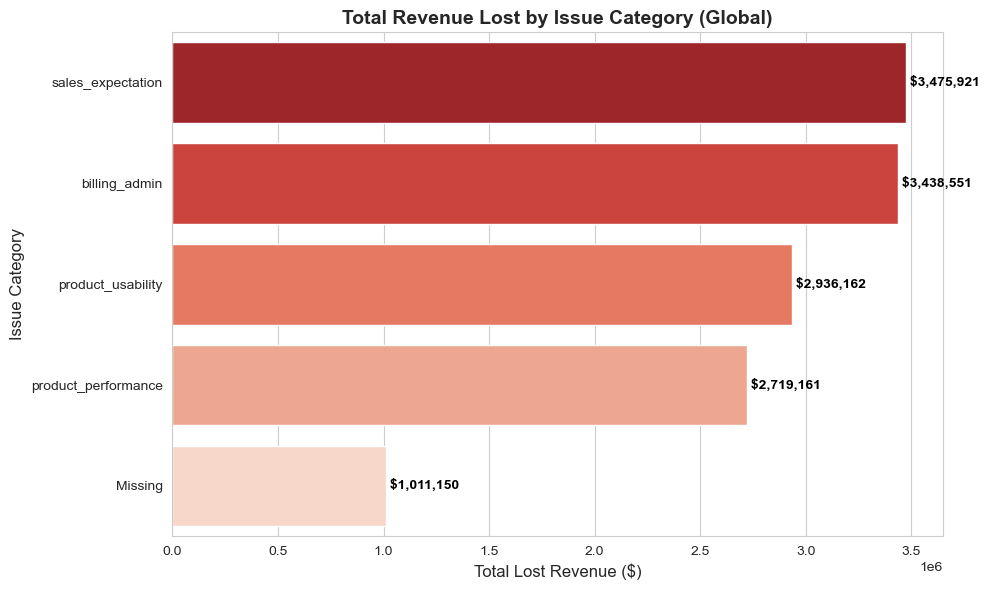

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Filter for ALL churned customers (ignoring clusters)
churned_overall = df_tickets[df_tickets["is_churned"] == 1].copy()

# 2) Group by Issue Category -> Sum Lost Revenue
overall_issue_loss = (
    churned_overall
    .groupby("issue_category")["lost_revenue"]
    .sum()
    .reset_index()
    .sort_values("lost_revenue", ascending=False)
)

# Calculate percentage share for context
total_loss = overall_issue_loss["lost_revenue"].sum()
overall_issue_loss["share_of_loss"] = (overall_issue_loss["lost_revenue"] / total_loss) * 100

print("\n=== Global Lost Revenue by Issue Category ===")
# Format for cleaner reading
print(overall_issue_loss.assign(
    lost_revenue=lambda x: x["lost_revenue"].apply(lambda v: f"${v:,.0f}"),
    share_of_loss=lambda x: x["share_of_loss"].apply(lambda v: f"{v:.1f}%")
))

# 3) Plotting
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create bar chart
ax = sns.barplot(
    data=overall_issue_loss,
    x="lost_revenue",
    y="issue_category",
    palette="Reds_r"  # Darkest red = highest loss
)

# Formatting
ax.set_title("Total Revenue Lost by Issue Category (Global)", fontsize=14, fontweight='bold')
ax.set_xlabel("Total Lost Revenue ($)", fontsize=12)
ax.set_ylabel("Issue Category", fontsize=12)

# Add dollar labels to the end of each bar
for i, v in enumerate(overall_issue_loss["lost_revenue"]):
    ax.text(v, i, f" ${v:,.0f}", va='center', fontweight='bold', color='black')

plt.tight_layout()
plt.show()

In [40]:
churned_overall["Q3_Status"]

2       During/After Q3
4       During/After Q3
20              Missing
126     During/After Q3
134     During/After Q3
135     During/After Q3
136     During/After Q3
167           Before Q3
168     During/After Q3
188           Before Q3
191     During/After Q3
192     During/After Q3
193           Before Q3
194     During/After Q3
195     During/After Q3
196     During/After Q3
197     During/After Q3
198     During/After Q3
199     During/After Q3
225     During/After Q3
264     During/After Q3
265     During/After Q3
280     During/After Q3
281     During/After Q3
282     During/After Q3
287           Before Q3
288     During/After Q3
289     During/After Q3
290     During/After Q3
291     During/After Q3
292     During/After Q3
318     During/After Q3
319     During/After Q3
320     During/After Q3
321     During/After Q3
334           Before Q3
335     During/After Q3
336     During/After Q3
337     During/After Q3
341             Missing
350     During/After Q3
353     During/A

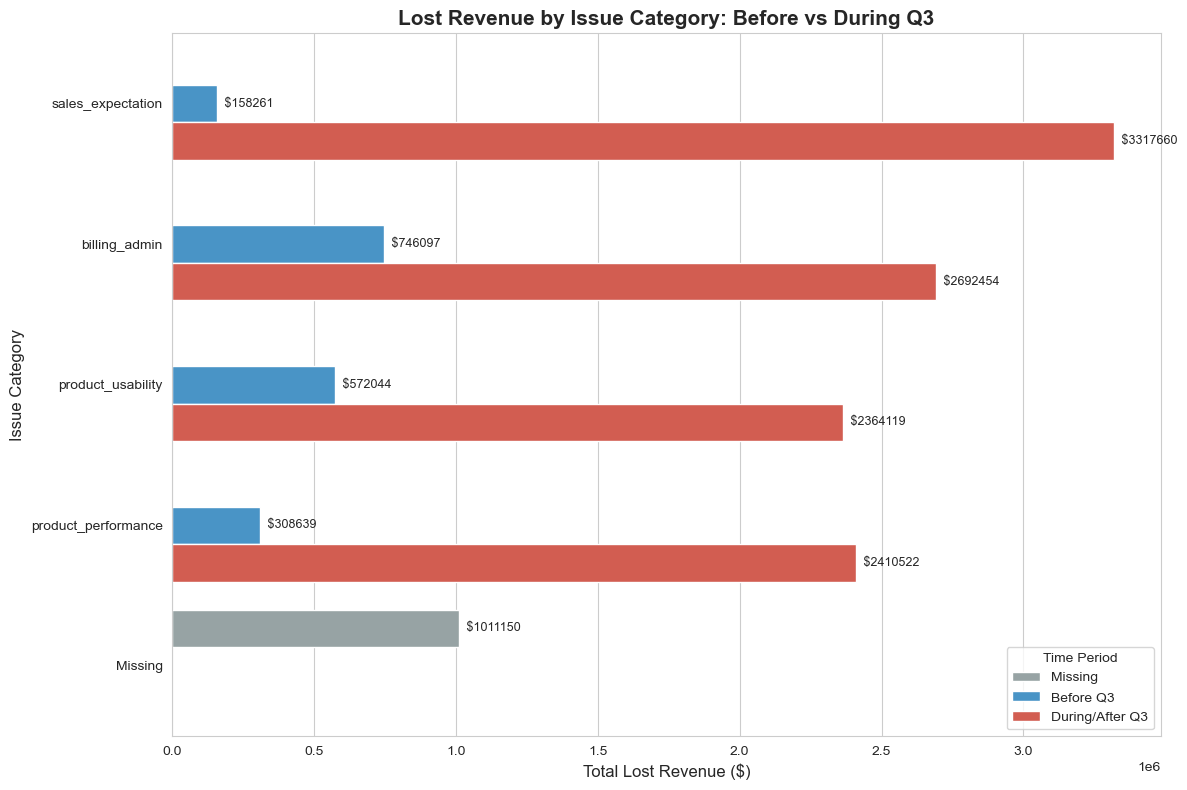


=== Lost Revenue by Issue & Period ===


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Filter for ALL churned customers
churned_overall = df_tickets[df_tickets["is_churned"] == 1].copy()

# 2) Group by Issue Category AND Q3 Status -> Sum Lost Revenue
cat_status_loss = (
    churned_overall
    .groupby(["issue_category", "Q3_Status"])["lost_revenue"]
    .sum()
    .reset_index()
)

# 3) Calculate Total Loss per Category (for sorting the chart)
# We want the biggest "Money Loser" categories at the top
category_totals = (
    cat_status_loss
    .groupby("issue_category")["lost_revenue"]
    .sum()
    .sort_values(ascending=False)
    .index
    .tolist()
)

# 4) PLOTTING: Grouped Bar Chart
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Use a custom palette: Blue for Before, Red for During/After
# Adjust the keys in 'palette' to match your exact Q3_Status string values
custom_palette = {
    "Before Q3": "#3498DB",       # Blue
    "During/After Q3": "#E74C3C",       # Red        # Darker Red (if present)
    "Missing": "#95A5A6"
}

# Create the plot
ax = sns.barplot(
    data=cat_status_loss,
    x="lost_revenue",
    y="issue_category",
    hue="Q3_Status",
    order=category_totals,    # Sort by total impact
    palette=custom_palette
)

# Formatting
ax.set_title("Lost Revenue by Issue Category: Before vs During Q3", fontsize=15, fontweight='bold')
ax.set_xlabel("Total Lost Revenue ($)", fontsize=12)
ax.set_ylabel("Issue Category", fontsize=12)
plt.legend(title="Time Period")

# Add value labels
# This iterates through the "containers" (the groups of bars)
for container in ax.containers:
    ax.bar_label(container, fmt=' $%.0f', padding=3, fontsize=9)

plt.tight_layout()
plt.show()

# 5) Print Data Table for Verification
print("\n=== Lost Revenue by Issue & Period ===")
pivot_table = cat_status_loss.pivot(index="issue_category", columns="Q3_Status", values="lost_revenue").fillna(0)
# Sort by the "During" column if it exists to see what's hurting you NOW
# sort_col = "During Q3" if "During Q3" in pivot_table.columns

In [ ]:
sales_cleaned

,Unnamed: 0,customer_id,company_name,country,region,is_eu,industry,company_size_bucket,annual_contract_value,product_tier,sales_segment,acquisition_channel,contract_start_date,contract_end_date,renewed_flag,discount_pct,initial_onboarding_score,is_churned,hier_cluster,lost_revenue,kmeans_cluster,hierarchical_cluster,kprototype_cluster,Q3_Status,channel,priority,issue_category,ticket_text,avg_sentiment,avg_first_response_hours,avg_resolution_hours,avg_resolved,ticket_count
0,0,C100000,Company_0,Canada,North America,0,Healthcare,51-200,12999.25,Growth,MidMarket,Partner,2023-05-02,NaN,1,0.03,7.0,0,3,0.00,2,3,1,Before Q3,Chat,Medium,product_performance,Dashboard loads very slowly during peak hours.,0.44,0.11,14.88,1.0,1.0
1,1,C100001,Company_1,UK,Europe,1,Wholesale,1-10,1799.72,Starter,SMB_Field,Inbound,2023-02-18,NaN,1,0.15,4.9,0,4,0.00,1,4,0,Before Q3,Email,Low,product_performance,Dashboard loads very slowly during peak hours.,-0.50,8.12,9.37,1.0,1.0
2,2,C100002,Company_2,US,North America,0,Manufacturing,1-10,1770.83,Starter,SMB_Field,Inbound,2023-11-12,2024-05-13,0,0.37,4.8,1,2,1770.83,0,2,2,During/After Q3,Email,Medium,product_usability,The new dashboard is confusing for my staff.,-0.50,2.97,31.65,1.0,1.0
3,3,C100003,Company_3,France,Europe,1,Missing,1-10,1790.30,Starter,SMB_Field,Outbound,2023-08-06,NaN,1,0.10,8.0,0,3,0.00,1,3,1,During/After Q3,Phone,High,billing_admin,I need to change our billing email and can't find the option.,-0.11,0.10,12.49,1.0,1.0
4,4,C100004,Company_4,Netherlands,Europe,1,Professional Services,1-10,1552.00,Starter,SMB_Inside,Inbound,2023-09-09,2024-03-10,0,0.11,3.8,1,4,1552.00,1,4,0,During/After Q3,Phone,Medium,product_performance,Inventory sync takes too long to complete.,0.20,5.19,35.67,1.0,1.0


In [53]:
df_tickets.groupby("kprototype_cluster")["lost_revenue"].sum()

kprototype_cluster
0    1565433.81
1    3419166.77
2    2930958.59
3    5665386.13
Name: lost_revenue, dtype: float64

In [34]:
df_priority.to_csv("data/df_priority.csv")


=== Within-cluster/period: churned vs retained ticket behavior ===
    kprototype_cluster        Q3_Status  is_churned  customers  avg_tickets  \
0                    0        Before Q3           0        462     1.006494   
1                    0        Before Q3           1         55     1.000000   
2                    0  During/After Q3           0       1239     1.005650   
3                    0  During/After Q3           1        182     1.000000   
4                    0          Missing           0        198     0.000000   
5                    0          Missing           1         44     0.000000   
6                    1        Before Q3           0        596     1.000000   
7                    1        Before Q3           1         36     1.000000   
8                    1  During/After Q3           0       1813     1.003861   
9                    1  During/After Q3           1        120     1.025000   
10                   1          Missing           0        181 

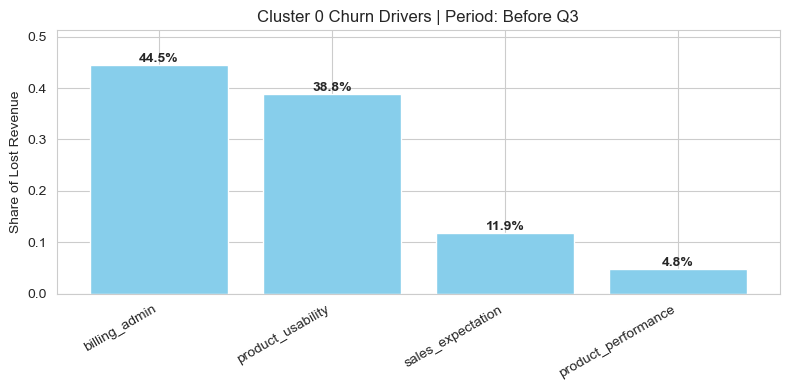


--- Data for Cluster 0 | Before Q3 ---
     issue_category  lost_revenue lost_share
      billing_admin     153178.41      44.5%
  product_usability     133506.87      38.8%
  sales_expectation      40790.39      11.9%
product_performance      16509.08       4.8%


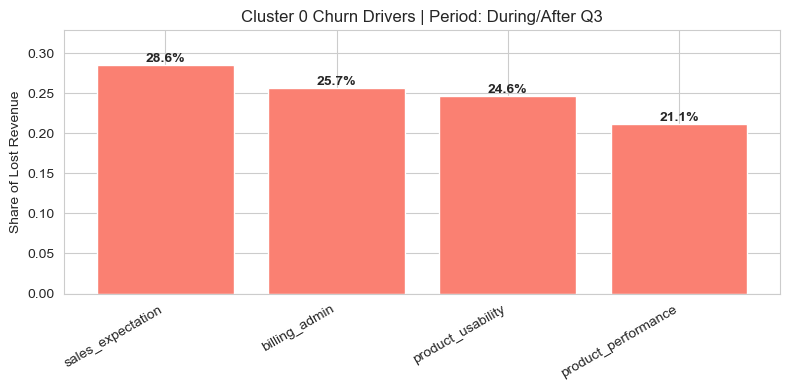


--- Data for Cluster 0 | During/After Q3 ---
     issue_category  lost_revenue lost_share
  sales_expectation     320382.36      28.6%
      billing_admin     288047.66      25.7%
  product_usability     275925.53      24.6%
product_performance     237122.44      21.1%


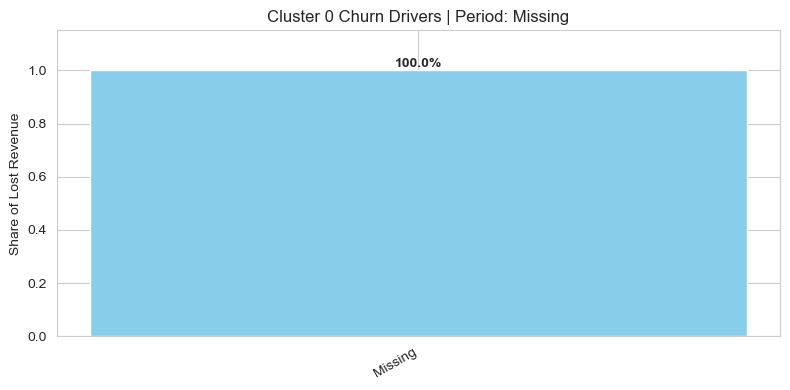


--- Data for Cluster 0 | Missing ---
issue_category  lost_revenue lost_share
       Missing      99971.07     100.0%


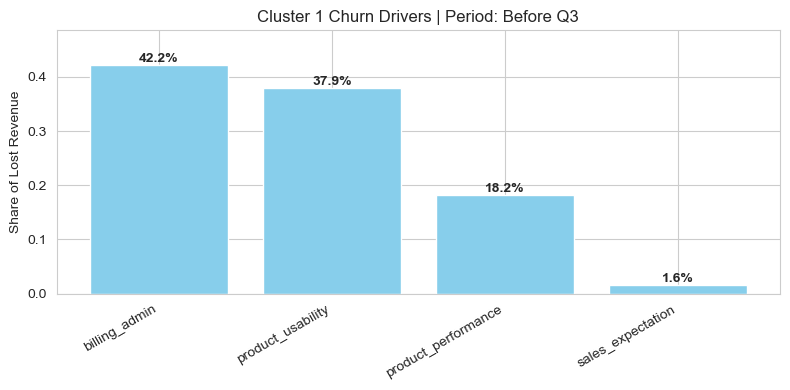


--- Data for Cluster 1 | Before Q3 ---
     issue_category  lost_revenue lost_share
      billing_admin     415644.99      42.2%
  product_usability     373410.73      37.9%
product_performance     179463.16      18.2%
  sales_expectation      15603.04       1.6%


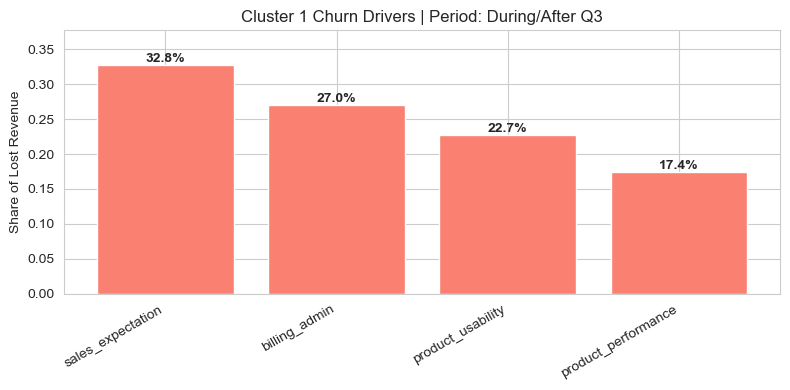


--- Data for Cluster 1 | During/After Q3 ---
     issue_category  lost_revenue lost_share
  sales_expectation     713219.43      32.8%
      billing_admin     586902.89      27.0%
  product_usability     494392.56      22.7%
product_performance     379217.34      17.4%


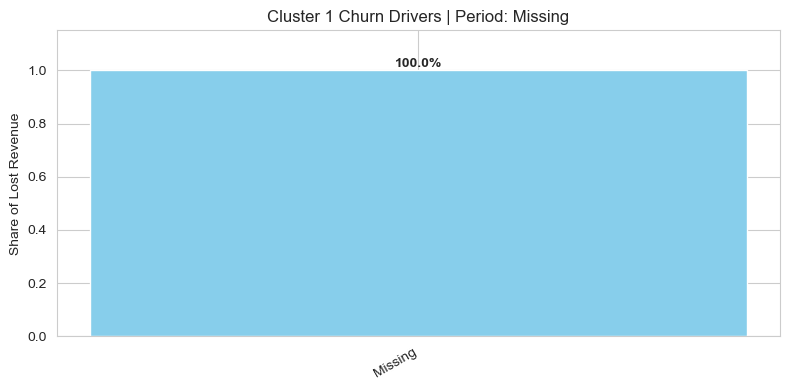


--- Data for Cluster 1 | Missing ---
issue_category  lost_revenue lost_share
       Missing     261312.63     100.0%


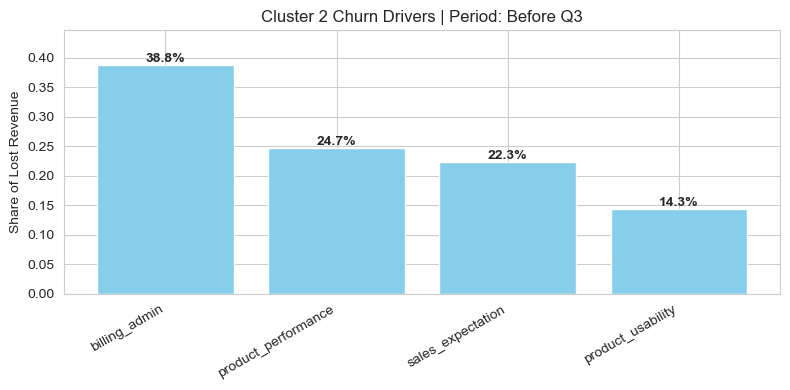


--- Data for Cluster 2 | Before Q3 ---
     issue_category  lost_revenue lost_share
      billing_admin     177273.26      38.8%
product_performance     112667.06      24.7%
  sales_expectation     101867.94      22.3%
  product_usability      65126.20      14.3%


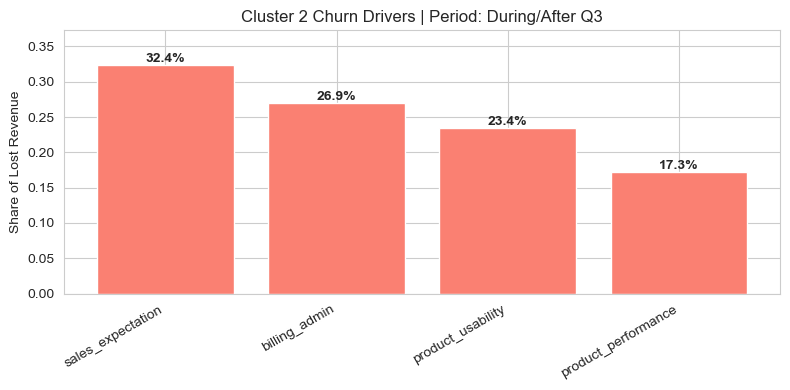


--- Data for Cluster 2 | During/After Q3 ---
     issue_category  lost_revenue lost_share
  sales_expectation     719958.44      32.4%
      billing_admin     598404.42      26.9%
  product_usability     519449.16      23.4%
product_performance     383893.62      17.3%


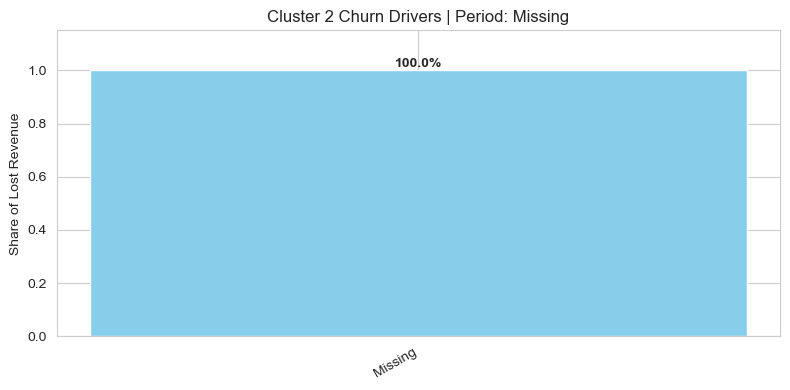


--- Data for Cluster 2 | Missing ---
issue_category  lost_revenue lost_share
       Missing     252318.49     100.0%


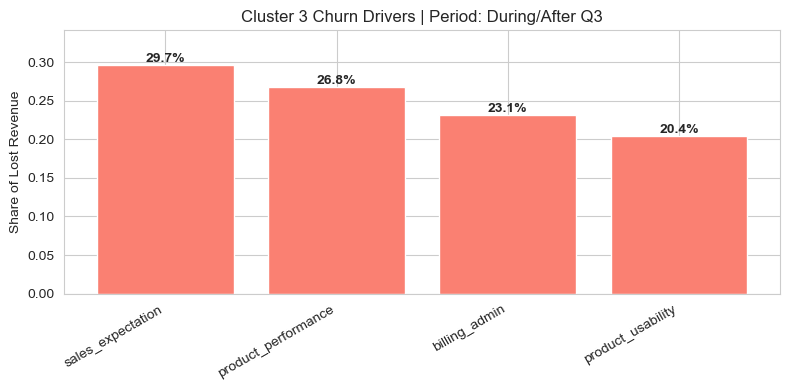


--- Data for Cluster 3 | During/After Q3 ---
     issue_category  lost_revenue lost_share
  sales_expectation    1564099.30      29.7%
product_performance    1410288.56      26.8%
      billing_admin    1219099.23      23.1%
  product_usability    1074351.42      20.4%


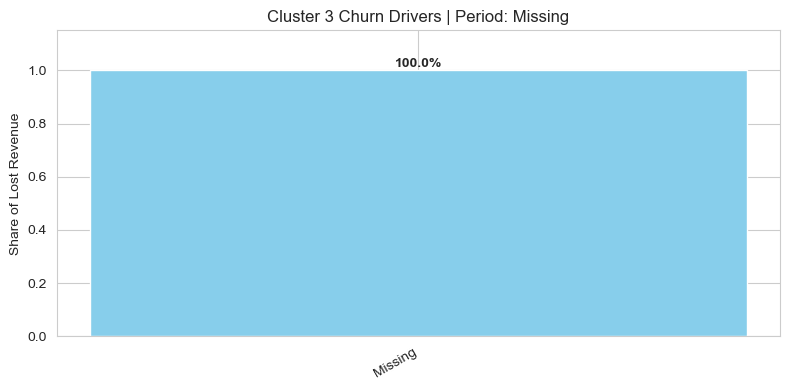


--- Data for Cluster 3 | Missing ---
issue_category  lost_revenue lost_share
       Missing     397547.62     100.0%


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ... [Keep your loading and merge code as is] ...

# 1) Pick priority clusters
priority_clusters = [0,1,2,3]
df_priority = df_tickets[df_tickets["kprototype_cluster"].isin(priority_clusters)].copy()

# 2) Cluster-level ticket + churn summary (Already includes Q3_Status from your prev step)
ticket_cluster_summary = (
    df_priority
    .groupby(["kprototype_cluster", "Q3_Status"])
    .agg(
        customers=("customer_id", "count"),
        churned=("is_churned", "sum"),
        churn_rate=("is_churned", "mean"),
        lost_revenue=("lost_revenue", "sum"),
        avg_tickets=("ticket_count", "mean"),
        avg_sentiment=("avg_sentiment", "mean"),
        avg_resolution_hours=("avg_resolution_hours", "mean"),
    )
    .reset_index()
    .sort_values(["kprototype_cluster", "Q3_Status"])
)

# 3) ADDED Q3_STATUS: Within each cluster & time period, churned vs retained behavior
# This helps see if the "vibe" of churners changed during the Q3 spike
ticket_churn_compare = (
    df_priority
    .groupby(["kprototype_cluster", "Q3_Status", "is_churned"])
    .agg(
        customers=("customer_id", "count"),
        avg_tickets=("ticket_count", "mean"),
        avg_sentiment=("avg_sentiment", "mean"),
        avg_resolution_hours=("avg_resolution_hours", "mean"),
    )
    .reset_index()
    .sort_values(["kprototype_cluster", "Q3_Status", "is_churned"])
)

print("\n=== Within-cluster/period: churned vs retained ticket behavior ===")
print(ticket_churn_compare)

# 4) ADDED Q3_STATUS: Top issue_category among churned per cluster AND period
# This identifies if the *reasons* for churn shifted in Q3
churned_only = df_priority[df_priority["is_churned"] == 1].copy()

churn_issue = (
    churned_only
    .groupby(["kprototype_cluster", "Q3_Status", "issue_category"])["lost_revenue"]
    .sum()
    .reset_index(name="lost_revenue")
)

# Normalize lost_share relative to that specific cluster AND that specific time period
churn_issue["group_lost_total"] = churn_issue.groupby(["kprototype_cluster", "Q3_Status"])["lost_revenue"].transform("sum")
churn_issue["lost_share"] = np.where(
    churn_issue["group_lost_total"] > 0,
    churn_issue["lost_revenue"] / churn_issue["group_lost_total"],
    0.0
)

# 5) PLOTTING: Loop through Cluster and Period
topk = 6
periods = sorted(churned_only["Q3_Status"].unique())

for hc in sorted(churned_only["kprototype_cluster"].unique()):
    for status in periods:
        sub = (churn_issue[(churn_issue["kprototype_cluster"] == hc) & (churn_issue["Q3_Status"] == status)]
               .sort_values("lost_share", ascending=False).head(topk))
        
        if sub.empty: continue
        
        fig, ax = plt.subplots(figsize=(8, 4))
        
        # Color Logic: Red for the "Crisis" period (During Q3), Blue for Baseline
        color = 'salmon' if 'During' in status else 'skyblue'
        
        # Draw Bars
        bars = ax.bar(sub["issue_category"].astype(str), sub["lost_share"], color=color)
        
        # Titles & Labels
        ax.set_title(f"Cluster {hc} Churn Drivers | Period: {status}")
        ax.set_ylabel("Share of Lost Revenue")
        ax.set_ylim(0, sub["lost_share"].max() * 1.15) # Add 15% headroom for labels
        plt.xticks(rotation=30, ha="right")
        
        # --- NEW CODE: Print Exact Proportions on the Graph ---
        for bar in bars:
            height = bar.get_height()
            # f"{height:.1%}" converts 0.125 -> "12.5%"
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1%}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
        # -------------------------------------------------------

        plt.tight_layout()
        plt.show()
        
        # Optional: Print table to console for verification
        print(f"\n--- Data for Cluster {hc} | {status} ---")
        print(sub[["issue_category", "lost_revenue", "lost_share"]]
              .assign(lost_share=lambda x: x["lost_share"].map(lambda v: f"{v:.1%}"))
              .to_string(index=False))

In [47]:
print(len(df_tickets))
df_tickets.head(5)

6973


,Unnamed: 0,customer_id,company_name,country,region,is_eu,industry,company_size_bucket,annual_contract_value,product_tier,sales_segment,acquisition_channel,contract_start_date,contract_end_date,renewed_flag,discount_pct,initial_onboarding_score,is_churned,hier_cluster,lost_revenue,kmeans_cluster,hierarchical_cluster,kprototype_cluster,Q3_Status,channel,priority,issue_category,ticket_text,avg_sentiment,avg_first_response_hours,avg_resolution_hours,avg_resolved,ticket_count
0,0,C100000,Company_0,Canada,North America,0,Healthcare,51-200,12999.25,Growth,MidMarket,Partner,2023-05-02,NaN,1,0.03,7.0,0,3,0.00,2,3,1,Before Q3,Chat,Medium,product_performance,Dashboard loads very slowly during peak hours.,0.44,0.11,14.88,1.0,1.0
1,1,C100001,Company_1,UK,Europe,1,Wholesale,1-10,1799.72,Starter,SMB_Field,Inbound,2023-02-18,NaN,1,0.15,4.9,0,4,0.00,1,4,0,Before Q3,Email,Low,product_performance,Dashboard loads very slowly during peak hours.,-0.50,8.12,9.37,1.0,1.0
2,2,C100002,Company_2,US,North America,0,Manufacturing,1-10,1770.83,Starter,SMB_Field,Inbound,2023-11-12,2024-05-13,0,0.37,4.8,1,2,1770.83,0,2,2,During/After Q3,Email,Medium,product_usability,The new dashboard is confusing for my staff.,-0.50,2.97,31.65,1.0,1.0
3,3,C100003,Company_3,France,Europe,1,Missing,1-10,1790.30,Starter,SMB_Field,Outbound,2023-08-06,NaN,1,0.10,8.0,0,3,0.00,1,3,1,During/After Q3,Phone,High,billing_admin,I need to change our billing email and can't find the option.,-0.11,0.10,12.49,1.0,1.0
4,4,C100004,Company_4,Netherlands,Europe,1,Professional Services,1-10,1552.00,Starter,SMB_Inside,Inbound,2023-09-09,2024-03-10,0,0.11,3.8,1,4,1552.00,1,4,0,During/After Q3,Phone,Medium,product_performance,Inventory sync takes too long to complete.,0.20,5.19,35.67,1.0,1.0



=== Within-cluster/period: churned vs retained ticket behavior ===
    kprototype_cluster        Q3_Status  is_churned  customers  avg_tickets  \
0                    0        Before Q3           0        462     1.006494   
1                    0        Before Q3           1         55     1.000000   
2                    0  During/After Q3           0       1239     1.005650   
3                    0  During/After Q3           1        182     1.000000   
4                    0          Missing           0        198     0.000000   
5                    0          Missing           1         44     0.000000   
6                    1        Before Q3           0        596     1.000000   
7                    1        Before Q3           1         36     1.000000   
8                    1  During/After Q3           0       1813     1.003861   
9                    1  During/After Q3           1        120     1.025000   
10                   1          Missing           0        181 

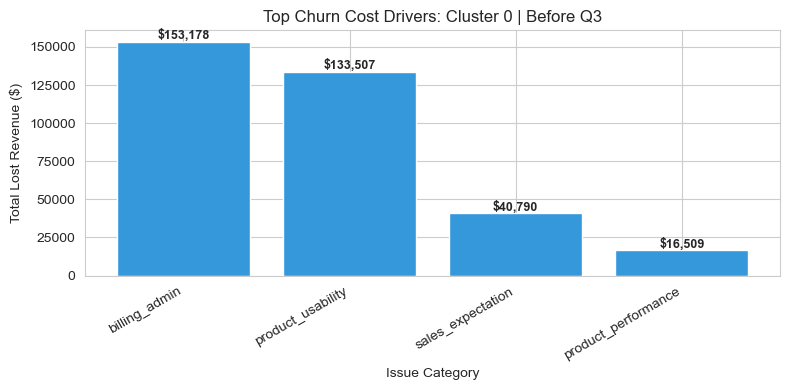


--- Exact Numbers: Cluster 0 | Before Q3 ---
     issue_category  lost_revenue
      billing_admin     153178.41
  product_usability     133506.87
  sales_expectation      40790.39
product_performance      16509.08


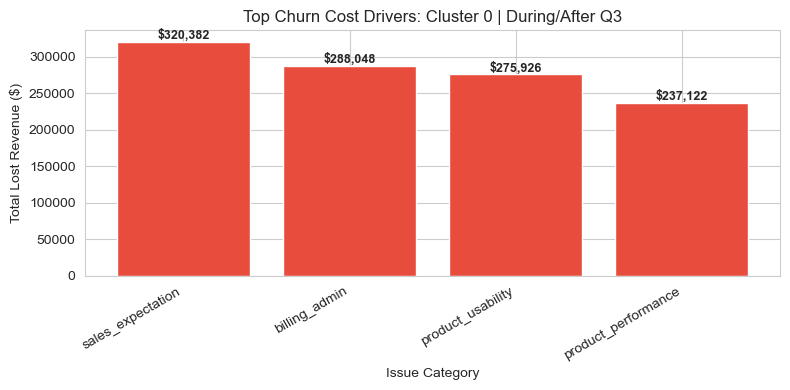


--- Exact Numbers: Cluster 0 | During/After Q3 ---
     issue_category  lost_revenue
  sales_expectation     320382.36
      billing_admin     288047.66
  product_usability     275925.53
product_performance     237122.44


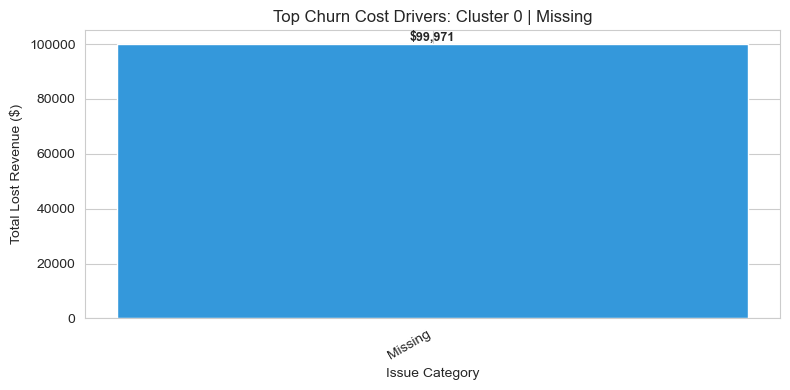


--- Exact Numbers: Cluster 0 | Missing ---
issue_category  lost_revenue
       Missing      99971.07


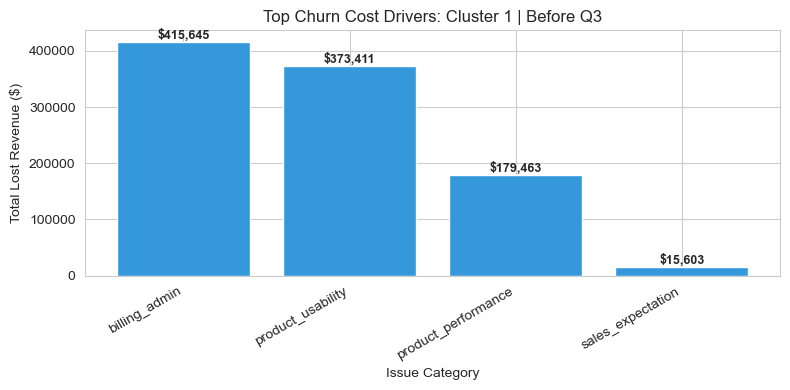


--- Exact Numbers: Cluster 1 | Before Q3 ---
     issue_category  lost_revenue
      billing_admin     415644.99
  product_usability     373410.73
product_performance     179463.16
  sales_expectation      15603.04


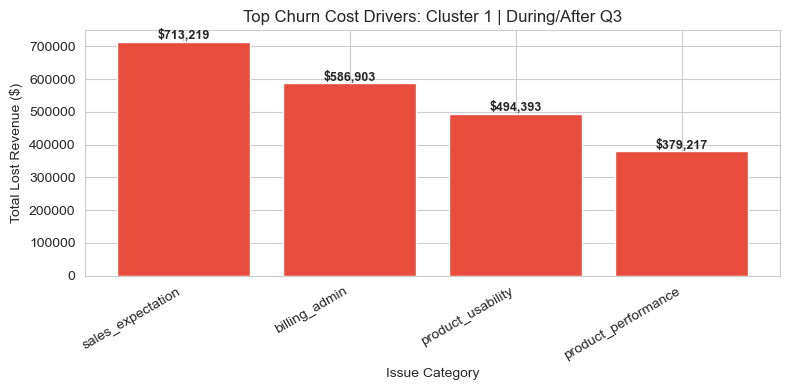


--- Exact Numbers: Cluster 1 | During/After Q3 ---
     issue_category  lost_revenue
  sales_expectation     713219.43
      billing_admin     586902.89
  product_usability     494392.56
product_performance     379217.34


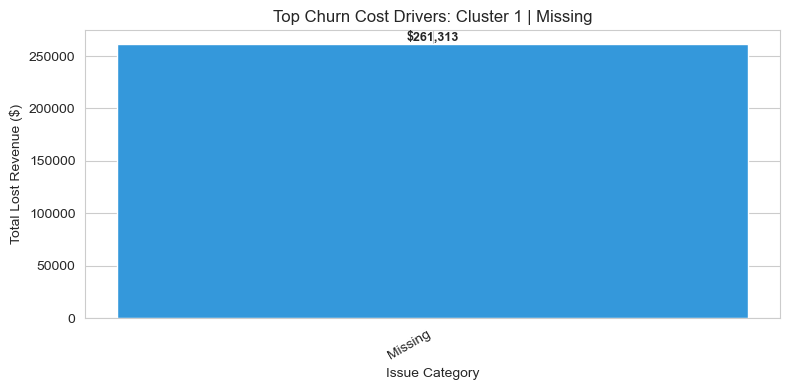


--- Exact Numbers: Cluster 1 | Missing ---
issue_category  lost_revenue
       Missing     261312.63


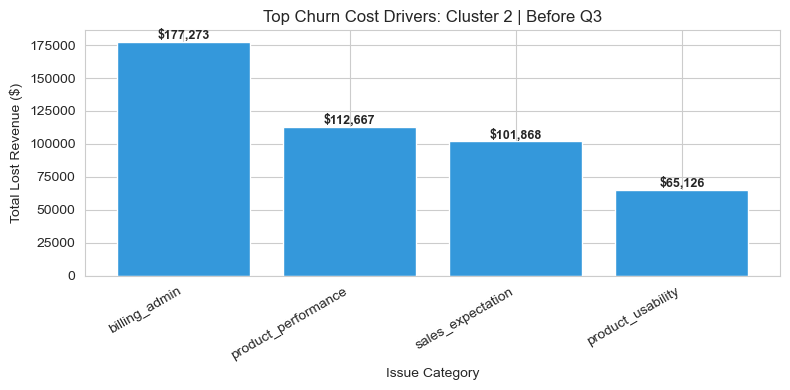


--- Exact Numbers: Cluster 2 | Before Q3 ---
     issue_category  lost_revenue
      billing_admin     177273.26
product_performance     112667.06
  sales_expectation     101867.94
  product_usability      65126.20


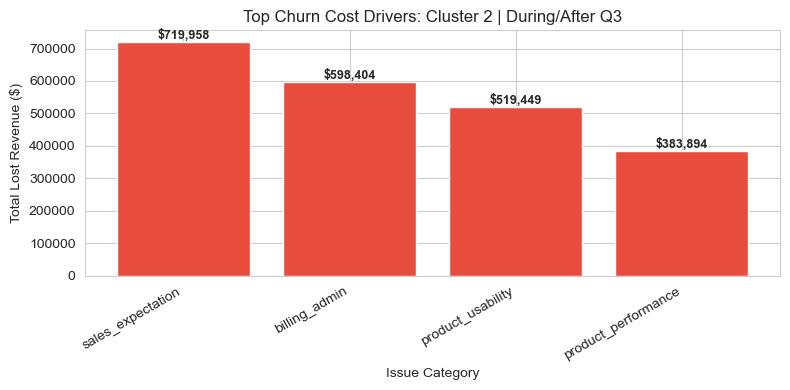


--- Exact Numbers: Cluster 2 | During/After Q3 ---
     issue_category  lost_revenue
  sales_expectation     719958.44
      billing_admin     598404.42
  product_usability     519449.16
product_performance     383893.62


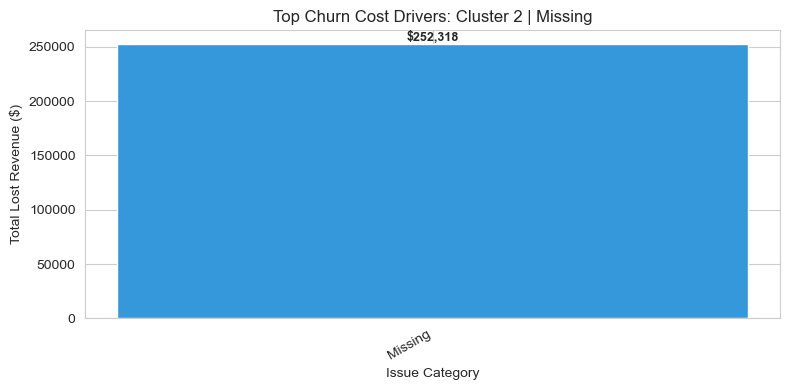


--- Exact Numbers: Cluster 2 | Missing ---
issue_category  lost_revenue
       Missing     252318.49


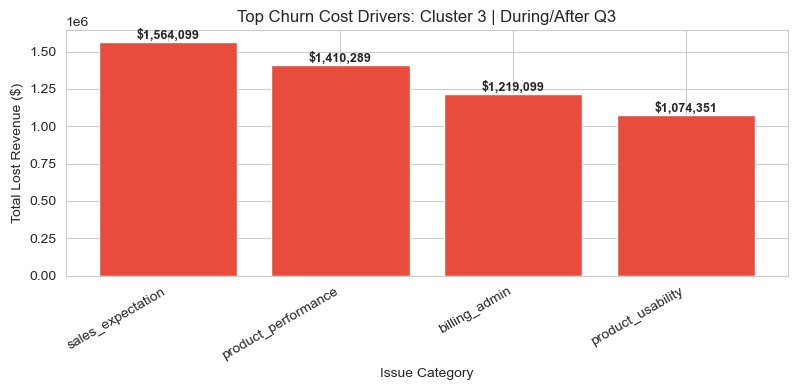


--- Exact Numbers: Cluster 3 | During/After Q3 ---
     issue_category  lost_revenue
  sales_expectation    1564099.30
product_performance    1410288.56
      billing_admin    1219099.23
  product_usability    1074351.42


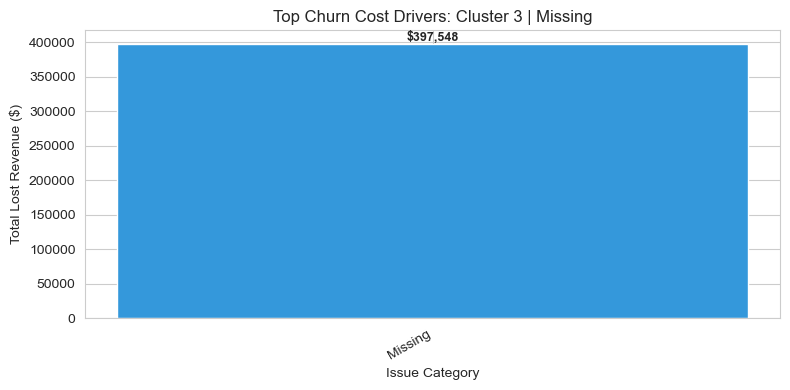


--- Exact Numbers: Cluster 3 | Missing ---
issue_category  lost_revenue
       Missing     397547.62

TOTAL NET REVENUE LOST SUMMARY
Total Revenue Lost (All Segments): $13,580,945.30

--- Loss by Time Period ---
During/After Q3      $10,784,754.36
Before Q3            $1,785,041.13
Missing              $1,011,149.81

--- Loss by Cluster ---
Cluster 3            $5,665,386.13
Cluster 1            $3,419,166.77
Cluster 2            $2,930,958.59
Cluster 0            $1,565,433.81


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ... [Keep your loading and merge code as is] ...

# 1) Pick priority clusters
priority_clusters = [0,1,2,3]
df_priority = df_tickets[df_tickets["kprototype_cluster"].isin(priority_clusters)].copy()

# 2) Cluster-level ticket + churn summary
ticket_cluster_summary = (
    df_priority
    .groupby(["kprototype_cluster", "Q3_Status"])
    .agg(
        customers=("customer_id", "count"),
        churned=("is_churned", "sum"),
        churn_rate=("is_churned", "mean"),
        lost_revenue=("lost_revenue", "sum"),
        avg_tickets=("ticket_count", "mean"),
        avg_sentiment=("avg_sentiment", "mean"),
        avg_resolution_hours=("avg_resolution_hours", "mean"),
    )
    .reset_index()
    .sort_values(["kprototype_cluster", "Q3_Status"])
)

# 3) Within each cluster & time period, churned vs retained behavior
ticket_churn_compare = (
    df_priority
    .groupby(["kprototype_cluster", "Q3_Status", "is_churned"])
    .agg(
        customers=("customer_id", "count"),
        avg_tickets=("ticket_count", "mean"),
        avg_sentiment=("avg_sentiment", "mean"),
        avg_resolution_hours=("avg_resolution_hours", "mean"),
    )
    .reset_index()
    .sort_values(["kprototype_cluster", "Q3_Status", "is_churned"])
)

print("\n=== Within-cluster/period: churned vs retained ticket behavior ===")
print(ticket_churn_compare)

# 4) Top issue_category among churned customers per cluster AND period
churned_only = df_priority[df_priority["is_churned"] == 1].copy()

churn_issue = (
    churned_only
    .groupby(["kprototype_cluster", "Q3_Status", "issue_category"])["lost_revenue"]
    .sum()
    .reset_index(name="lost_revenue")
)

# 5) PLOTTING: Loop through Cluster and Period based on TOTAL LOST REVENUE
topk = 6
periods = sorted(churned_only["Q3_Status"].unique())

for hc in sorted(churned_only["kprototype_cluster"].unique()):
    for status in periods:
        # Filter for the specific Cluster + Period
        sub = churn_issue[(churn_issue["kprototype_cluster"] == hc) & (churn_issue["Q3_Status"] == status)]
        
        # Sort by TOTAL LOST REVENUE to find the biggest dollar drivers
        sub = sub.sort_values("lost_revenue", ascending=False).head(topk)
        
        if sub.empty: continue
        
        fig, ax = plt.subplots(figsize=(8, 4))
        
        # Use Red for "During/After Q3" to highlight the crisis
        color = '#E74C3C' if 'During' in status else '#3498DB'
        
        # Plot absolute Lost Revenue
        bars = ax.bar(sub["issue_category"].astype(str), sub["lost_revenue"], color=color)
        
        # Formatting
        ax.set_title(f"Top Churn Cost Drivers: Cluster {hc} | {status}")
        ax.set_ylabel("Total Lost Revenue ($)")
        ax.set_xlabel("Issue Category")
        plt.xticks(rotation=30, ha="right")
        
        # FIX: Add dollar labels to the bars
        # We use a loop to place the text above each bar
        for i, v in enumerate(sub["lost_revenue"]):
            ax.text(i, v, f"${v:,.0f}", ha='center', va='bottom', fontsize=9, fontweight='bold')

        plt.tight_layout()
        plt.show()
        
        # PRINT EXACT NUMBERS FOR THIS CHART
        print(f"\n--- Exact Numbers: Cluster {hc} | {status} ---")
        print(sub[["issue_category", "lost_revenue"]].to_string(index=False))

# 6) GLOBAL SUMMARY: Total Net Revenue Lost
print("\n" + "="*40)
print("TOTAL NET REVENUE LOST SUMMARY")
print("="*40)

# Total Loss
total_lost = churned_only["lost_revenue"].sum()
print(f"Total Revenue Lost (All Segments): ${total_lost:,.2f}")

# Breakdown by Period
print("\n--- Loss by Time Period ---")
period_loss = churned_only.groupby("Q3_Status")["lost_revenue"].sum().sort_values(ascending=False)
for period, amount in period_loss.items():
    print(f"{period:<20} ${amount:,.2f}")

# Breakdown by Cluster
print("\n--- Loss by Cluster ---")
cluster_loss = churned_only.groupby("kprototype_cluster")["lost_revenue"].sum().sort_values(ascending=False)
for cluster, amount in cluster_loss.items():
    print(f"Cluster {cluster:<12} ${amount:,.2f}")

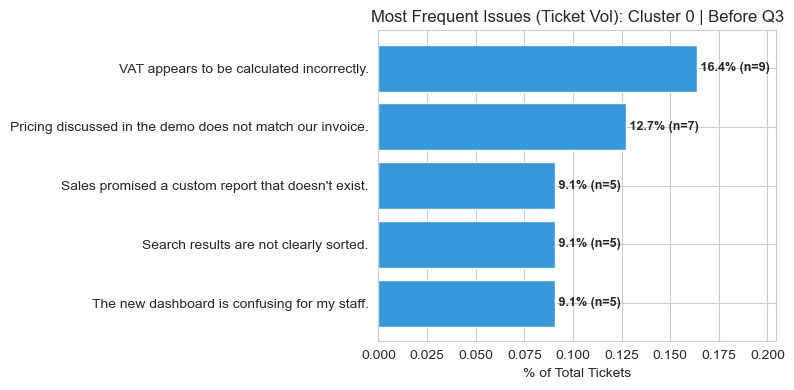

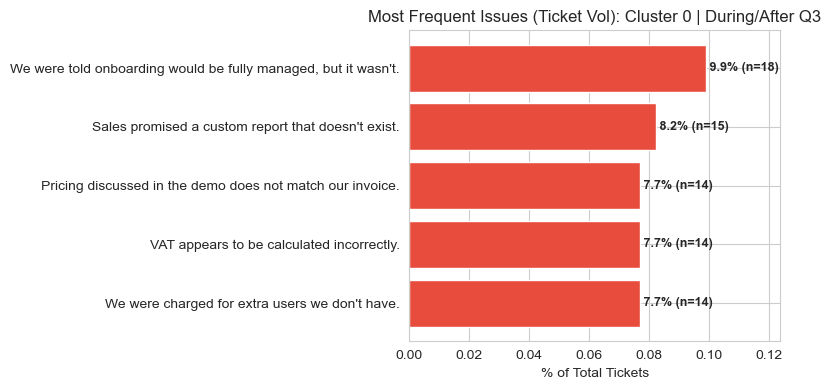

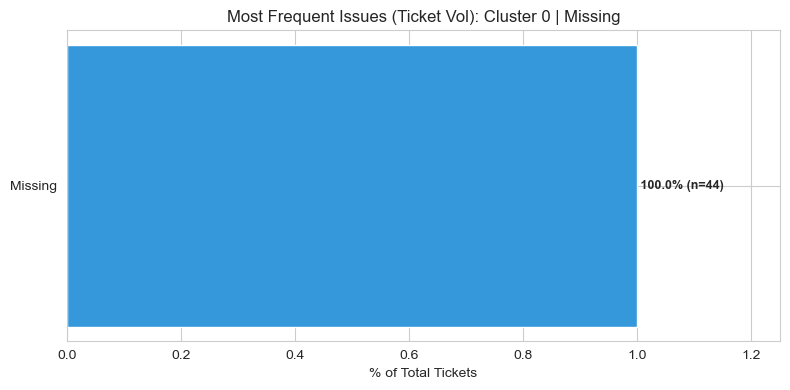

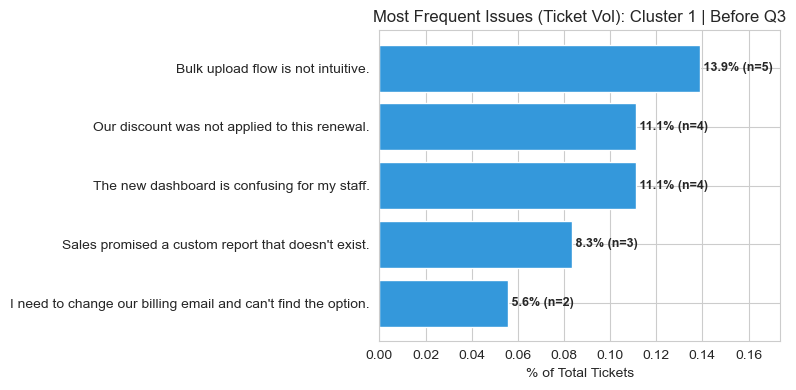

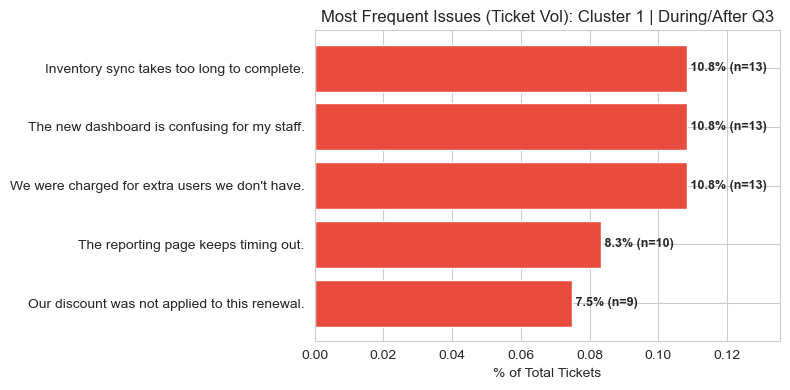

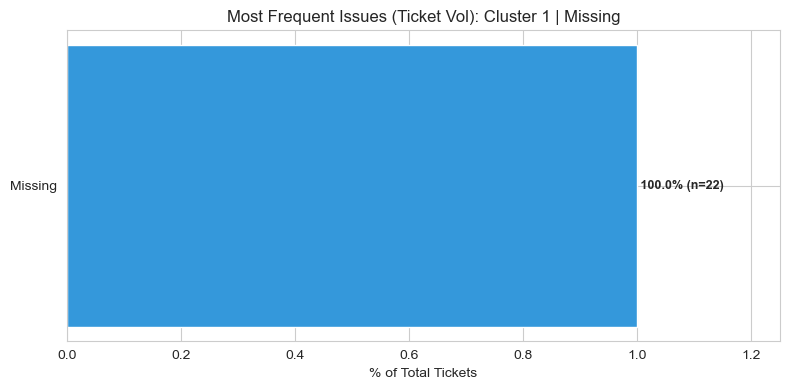

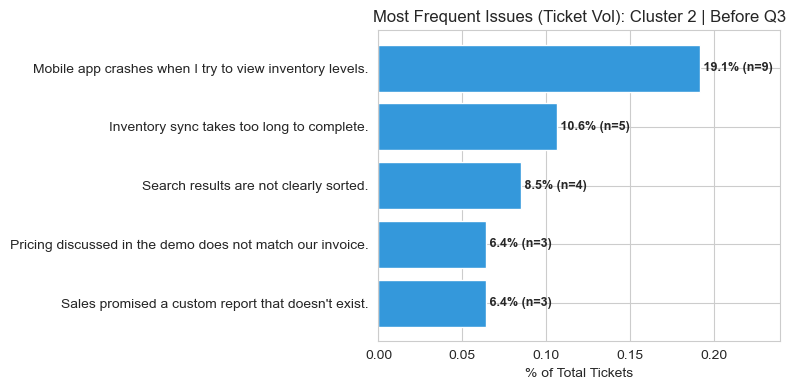

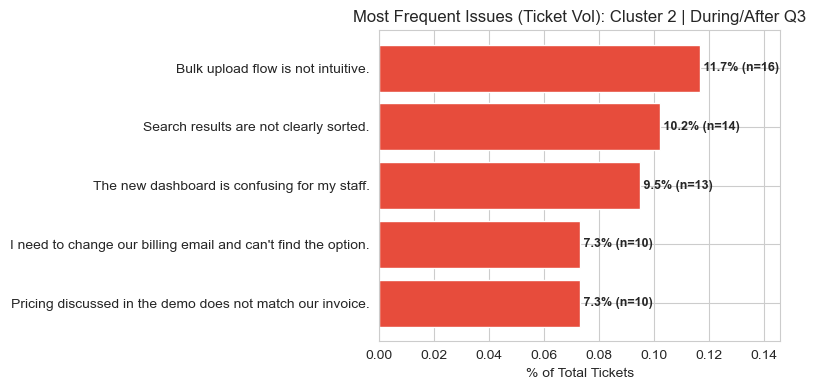

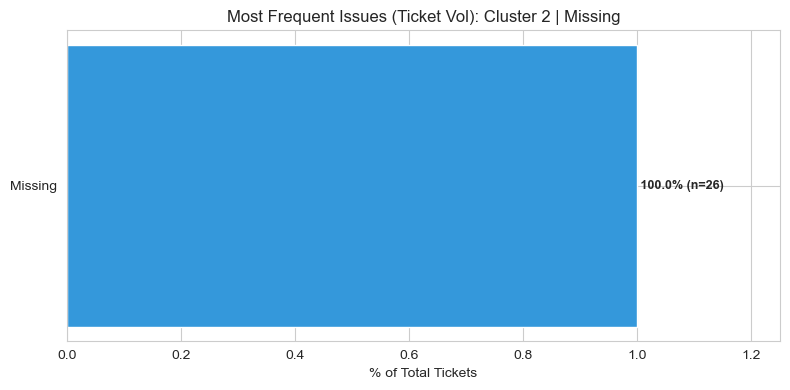

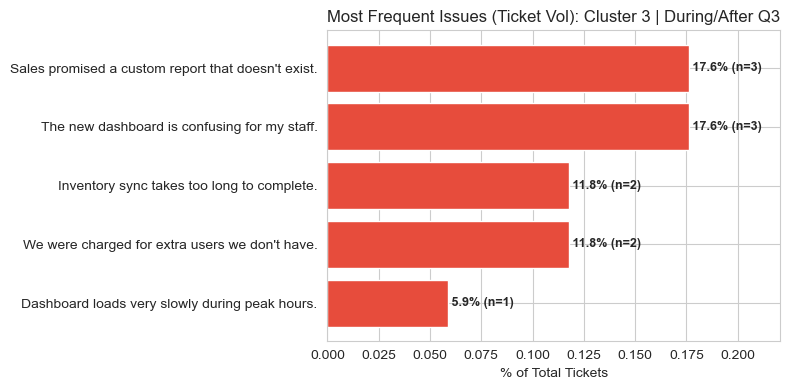

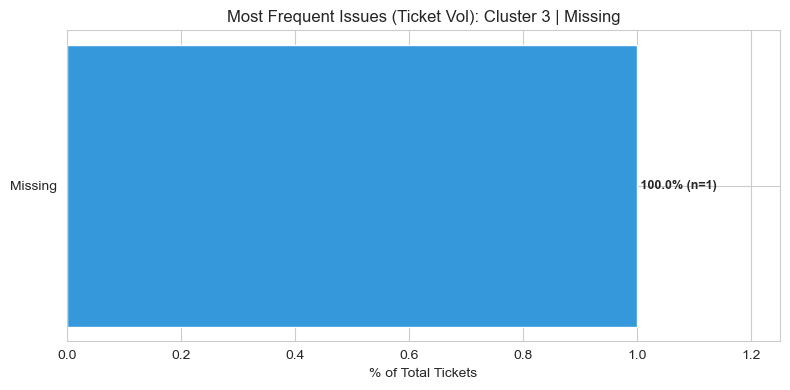

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ... [Assuming df_priority is already loaded] ...

# 1) Filter for CHURNED customers only
churned_only = df_priority[df_priority["is_churned"] == 1].copy()

# 2) Group by Cluster, Period, and Ticket Text -> COUNT tickets
ticket_vol_drivers = (
    churned_only
    .groupby(["kprototype_cluster", "Q3_Status", "ticket_text"])
    .size() # Count the rows (tickets)
    .reset_index(name="ticket_count")
)

# 3) Calculate Percentage of Tickets within that Cluster/Period
ticket_vol_drivers["group_total"] = ticket_vol_drivers.groupby(["kprototype_cluster", "Q3_Status"])["ticket_count"].transform("sum")
ticket_vol_drivers["pct_tickets"] = ticket_vol_drivers["ticket_count"] / ticket_vol_drivers["group_total"]

# 4) PLOTTING
topk = 5
periods = sorted(churned_only["Q3_Status"].unique())

for hc in sorted(churned_only["kprototype_cluster"].unique()):
    for status in periods:
        
        # Filter
        sub = ticket_vol_drivers[
            (ticket_vol_drivers["kprototype_cluster"] == hc) & 
            (ticket_vol_drivers["Q3_Status"] == status)
        ]
        
        # Sort by PERCENTAGE OF TICKETS
        sub = sub.sort_values("pct_tickets", ascending=False).head(topk)
        
        if sub.empty: continue
        
        fig, ax = plt.subplots(figsize=(8, 4))
        
        # Color: Red for "During Q3", Blue for "Before"
        color = '#E74C3C' if 'During' in status else '#3498DB'
        
        # Plot Horizontal Bar
        ax.barh(sub["ticket_text"].astype(str), sub["pct_tickets"], color=color)
        ax.invert_yaxis() # Top reason at the top
        
        # Formatting
        ax.set_title(f"Most Frequent Issues (Ticket Vol): Cluster {hc} | {status}")
        ax.set_xlabel("% of Total Tickets")
        
        # Add labels: "25.0% (n=120)"
        for i, (pct, count) in enumerate(zip(sub["pct_tickets"], sub["ticket_count"])):
            label = f" {pct:.1%} (n={count})"
            ax.text(pct, i, label, ha='left', va='center', fontsize=9, fontweight='bold')

        # Add some space on the right for labels
        ax.set_xlim(0, sub["pct_tickets"].max() * 1.25)
        
        plt.tight_layout()
        plt.show()

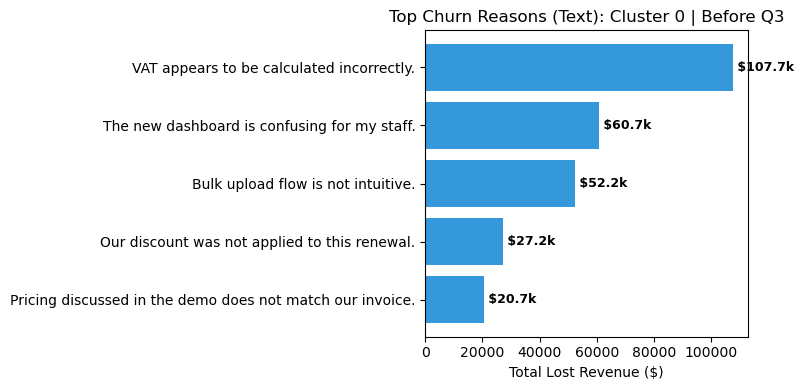

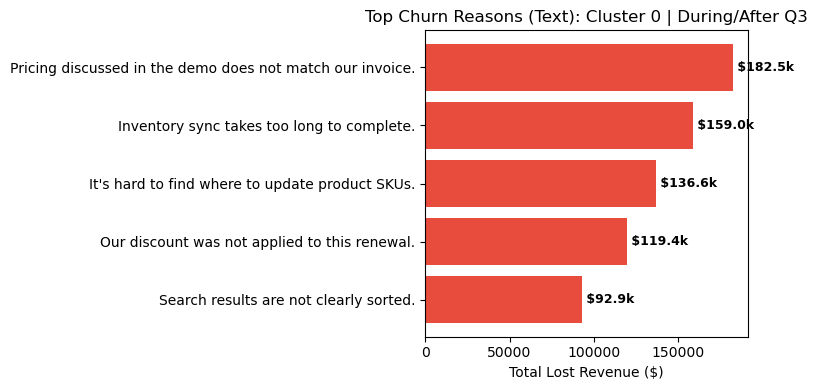

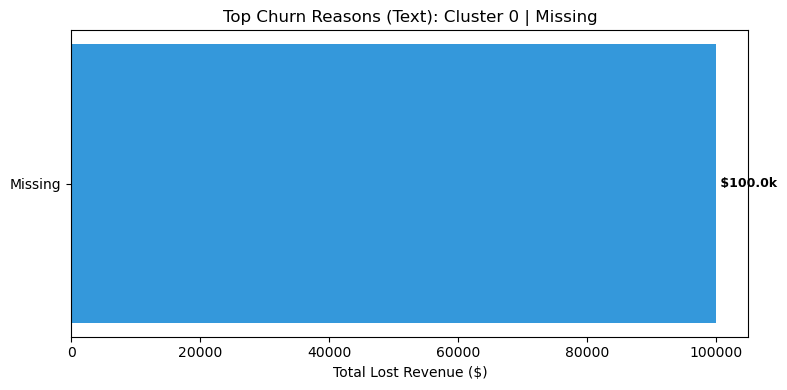

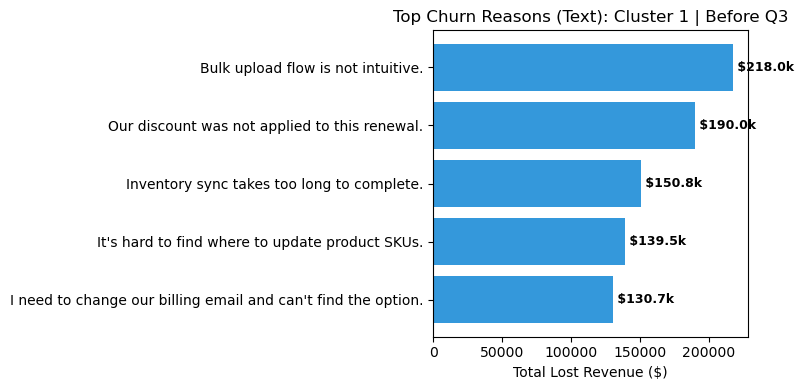

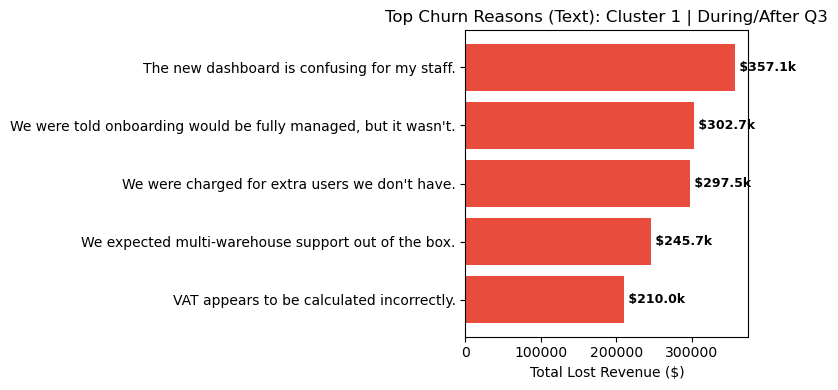

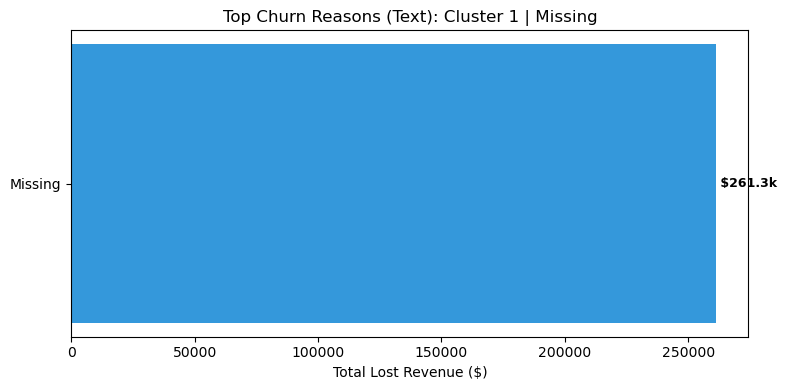

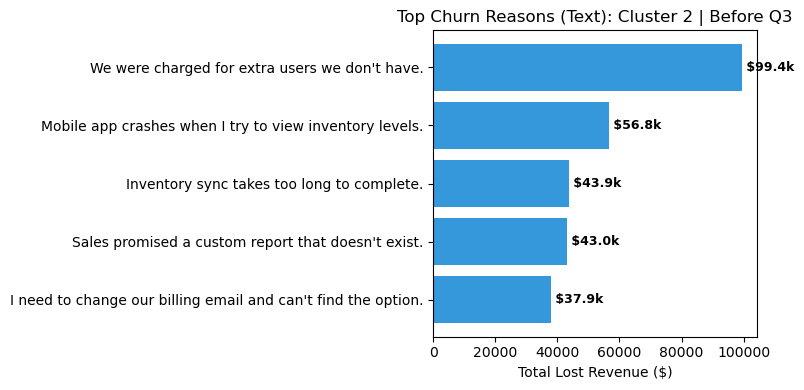

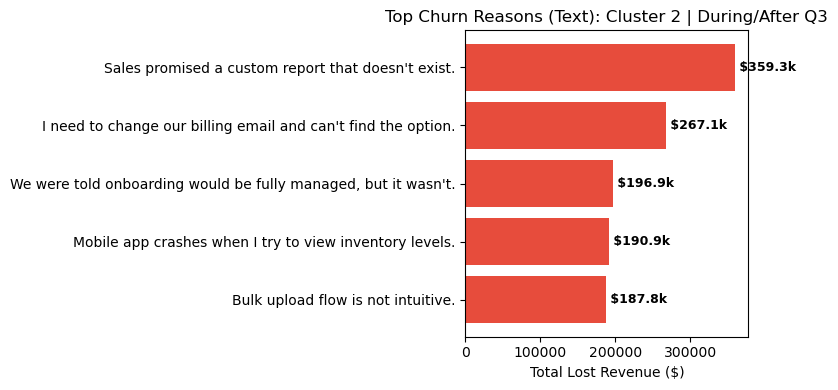

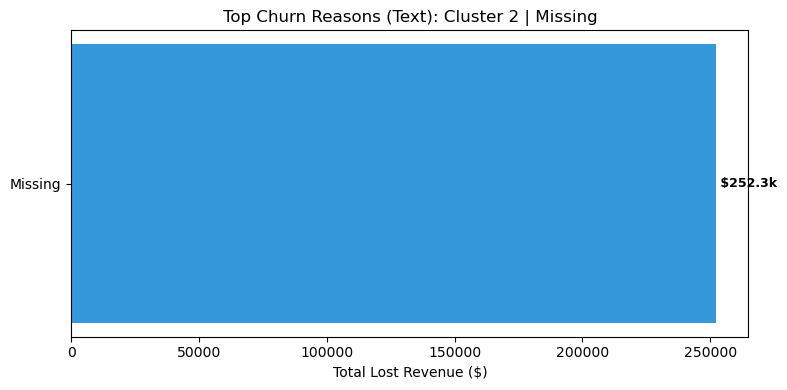

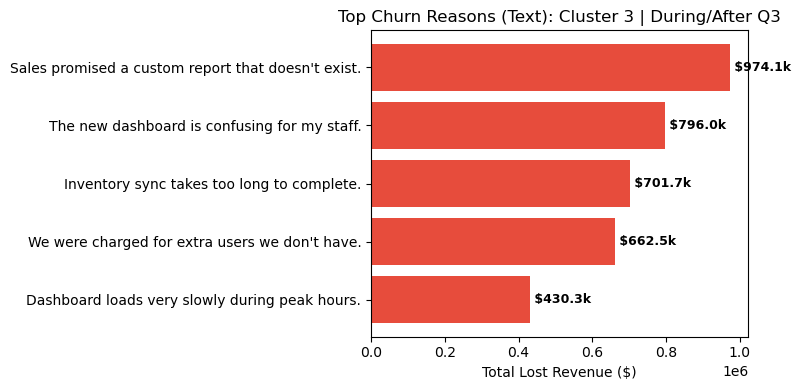

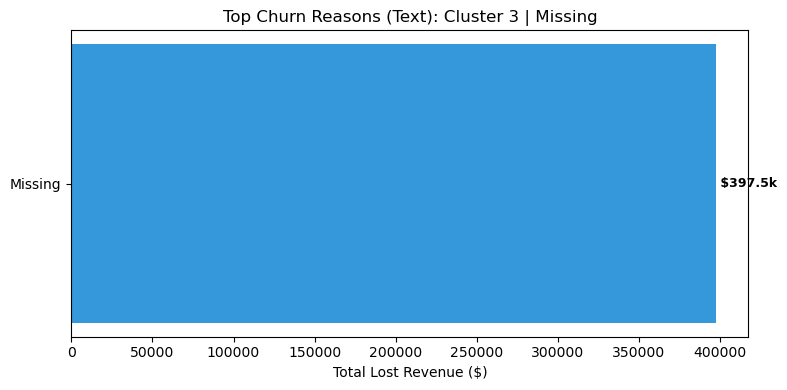

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ... [Keep your loading and merge code as is] ...

# 1) Pick priority clusters
priority_clusters = [0,1,2,3]
df_priority = df_tickets[df_tickets["kprototype_cluster"].isin(priority_clusters)].copy()

# 2) Filter for CHURNED customers only (since we want to explain the loss)
churned_only = df_priority[df_priority["is_churned"] == 1].copy()

# 3) Group by Cluster, Period, AND Ticket Text
# This effectively pivots the data to show "Revenue Lost per Ticket Topic"
churn_text_drivers = (
    churned_only
    .groupby(["kprototype_cluster", "Q3_Status", "ticket_text"])["lost_revenue"]
    .sum()
    .reset_index(name="lost_revenue")
)

# 4) PLOTTING: Loop through Cluster and Period
# We want to compare "Before Q3" drivers vs "During Q3" drivers
topk = 5
periods = sorted(churned_only["Q3_Status"].unique())

for hc in sorted(churned_only["kprototype_cluster"].unique()):
    for status in periods:
        
        # Filter for the specific Cluster + Period
        sub = churn_text_drivers[
            (churn_text_drivers["kprototype_cluster"] == hc) & 
            (churn_text_drivers["Q3_Status"] == status)
        ]
        
        # Sort by TOTAL LOST REVENUE to find the "expensive" problems
        sub = sub.sort_values("lost_revenue", ascending=False).head(topk)
        
        if sub.empty: continue
        
        fig, ax = plt.subplots(figsize=(8, 4))
        
        # Use Red for Q3 to highlight the "Crisis" period
        color = '#E74C3C' if 'During' in status else '#3498DB'
        
        # Plot absolute Lost Revenue on the Y-axis
        # We use 'ticket_text' as the category now
        ax.barh(sub["ticket_text"].astype(str), sub["lost_revenue"], color=color)
        ax.invert_yaxis() # Put the biggest money loser at the top
        
        # Formatting
        ax.set_title(f"Top Churn Reasons (Text): Cluster {hc} | {status}")
        ax.set_xlabel("Total Lost Revenue ($)")
        
        # Add dollar labels to the bars
        for i, v in enumerate(sub["lost_revenue"]):
            ax.text(v, i, f" ${v/1000:.1f}k", ha='left', va='center', fontsize=9, fontweight='bold')

        plt.tight_layout()
        plt.show()

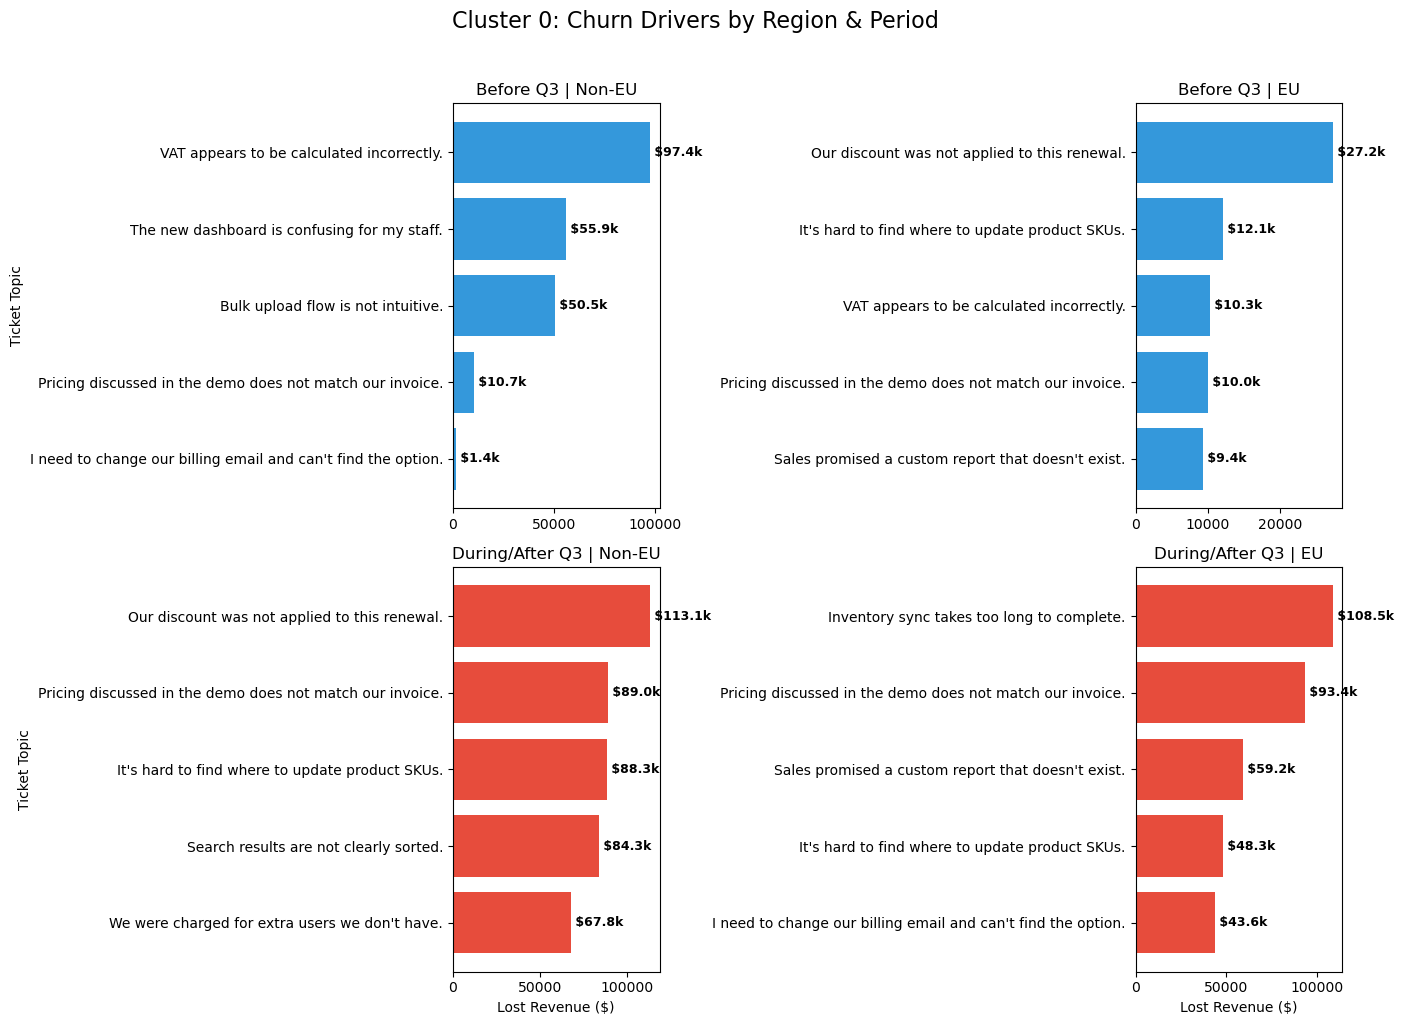

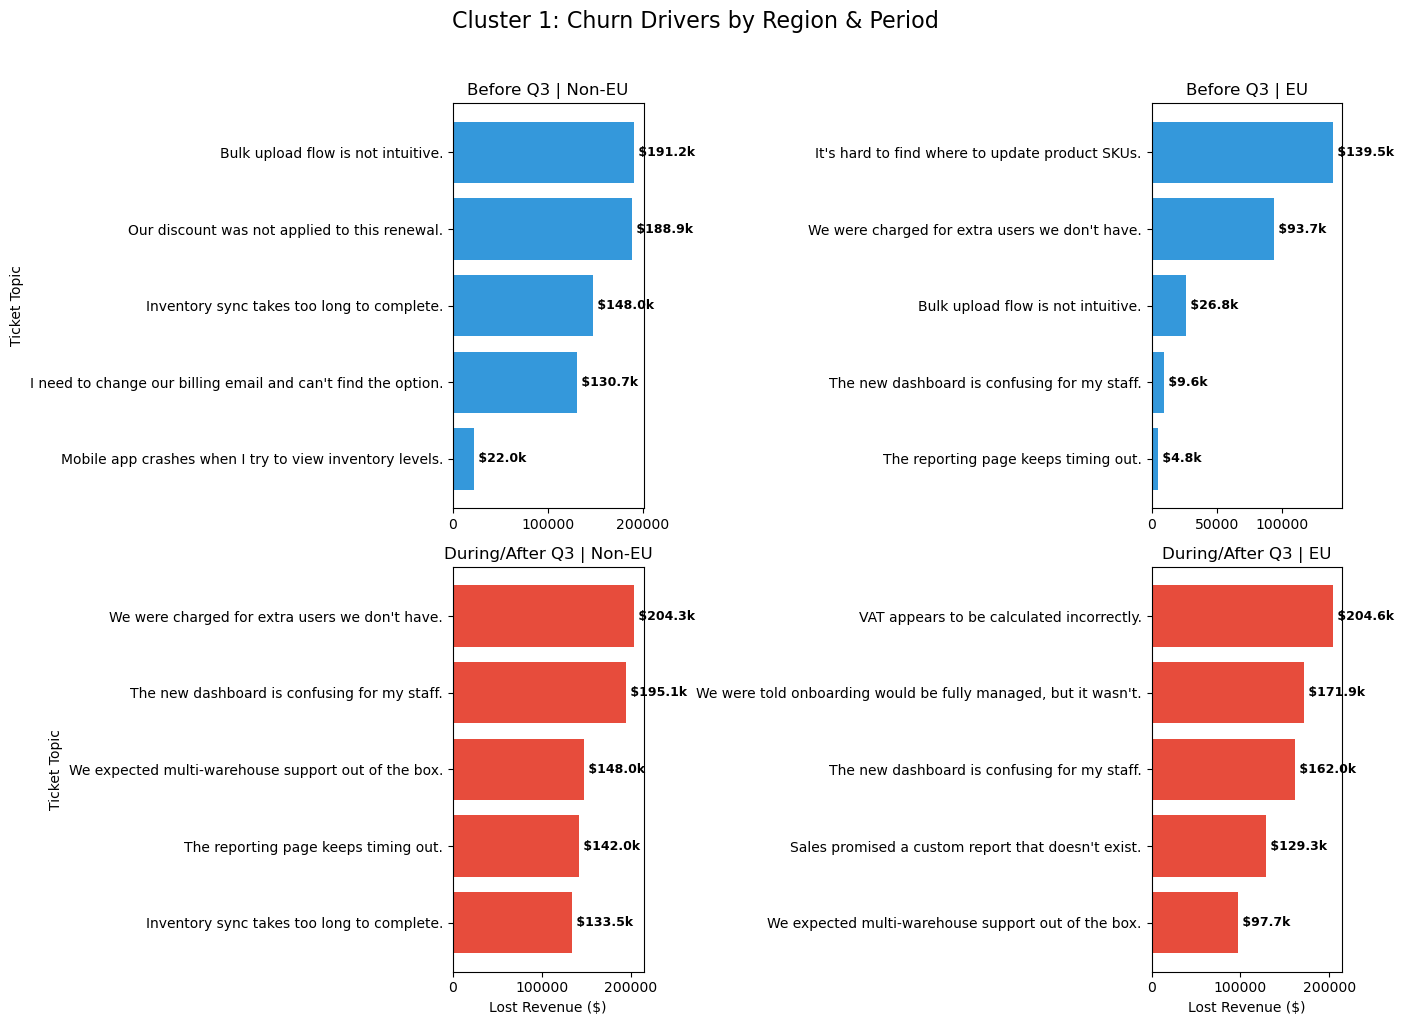

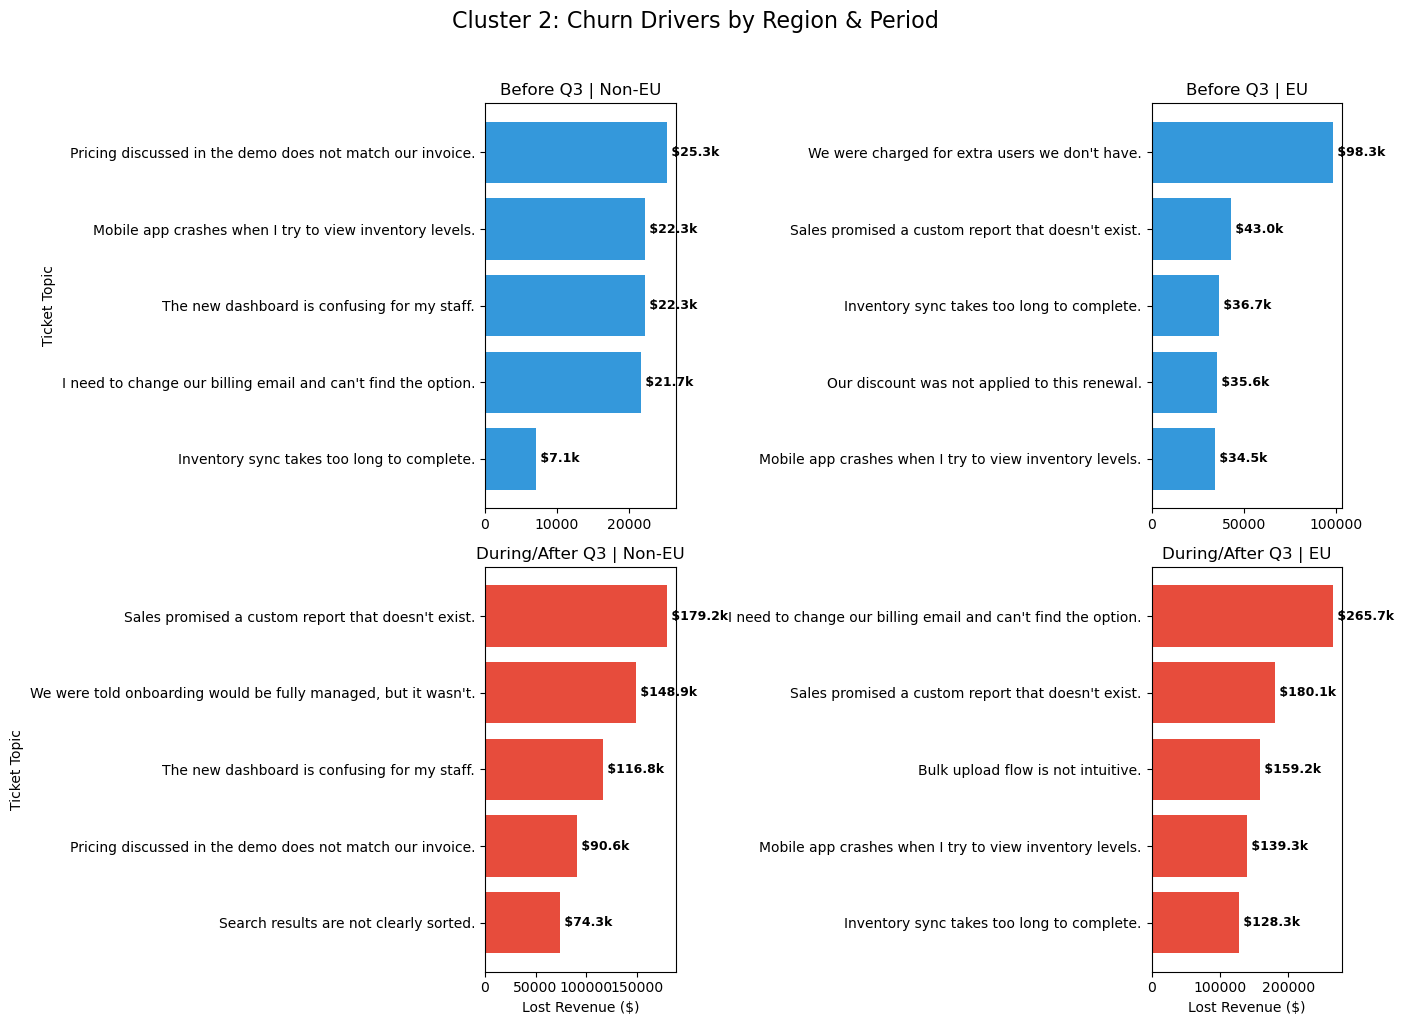

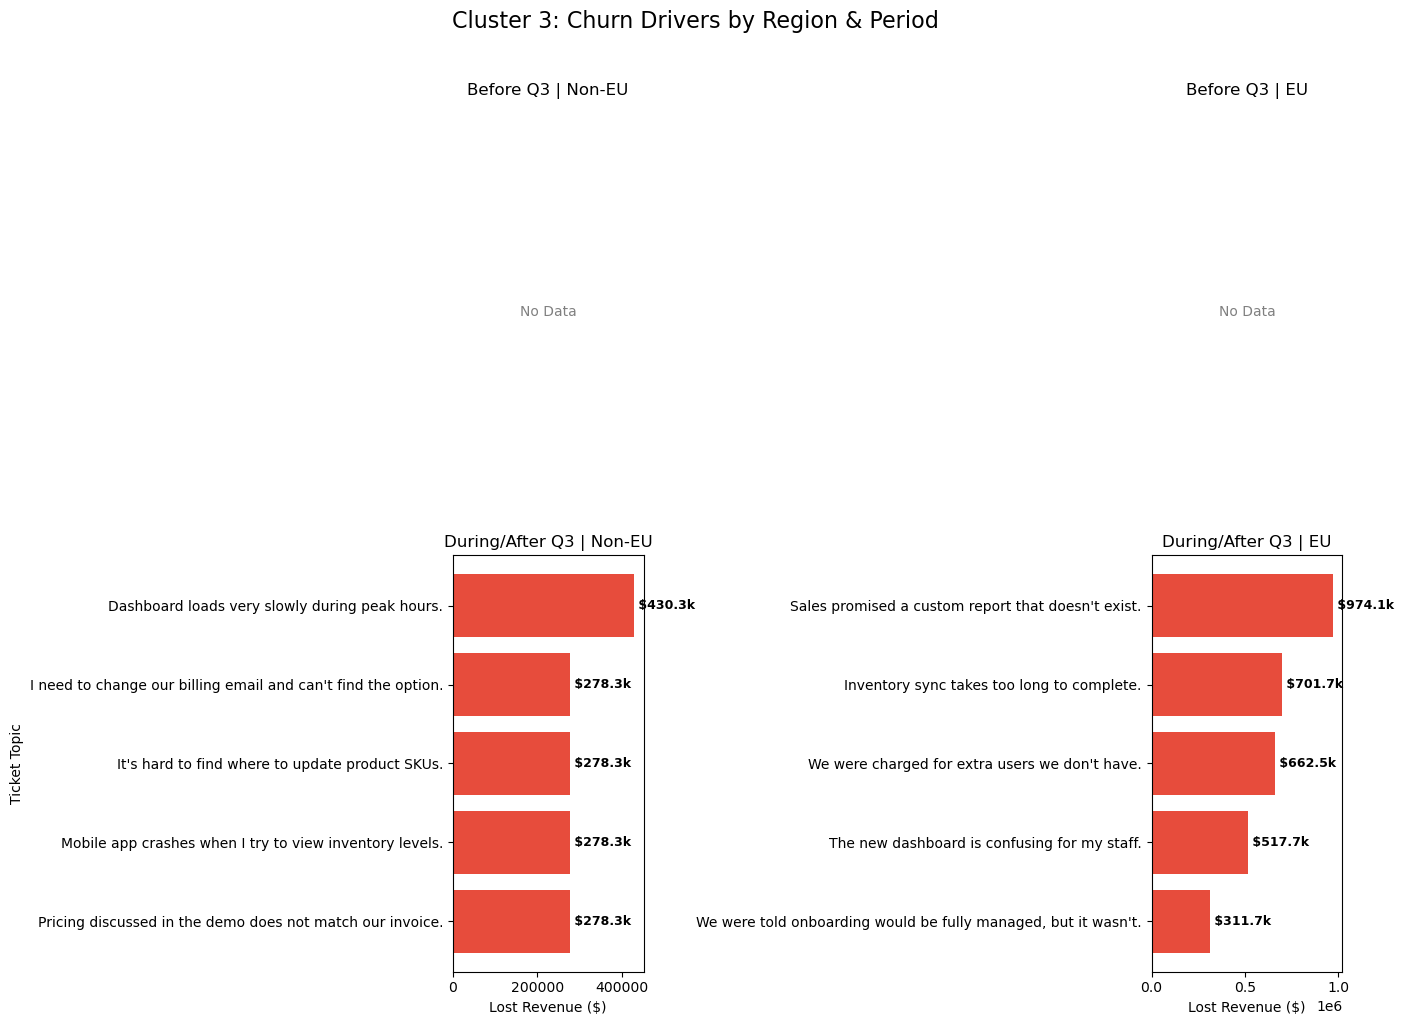

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ... [Keep your loading and merge code as is] ...

# 1) Pick priority clusters
priority_clusters = [0,1,2,3]
df_priority = df_tickets[df_tickets["kprototype_cluster"].isin(priority_clusters)].copy()

# 2) Filter for CHURNED customers only
churned_only = df_priority[df_priority["is_churned"] == 1].copy()

# Ensure is_eu is standard (0/1 or False/True) -> Map to String for cleaner plots
# (Adjust logic if your column is already 'Yes'/'No')
churned_only['region_label'] = churned_only['is_eu'].apply(lambda x: "EU" if x == 1 else "Non-EU")

# 3) Group by Cluster, Region, Period, AND Ticket Text
# This now pivots data by 4 dimensions
churn_text_drivers = (
    churned_only
    .groupby(["kprototype_cluster", "region_label", "Q3_Status", "ticket_text"])["lost_revenue"]
    .sum()
    .reset_index(name="lost_revenue")
)

# 4) PLOTTING: Create a 2x2 Grid for each Cluster
topk = 5
periods = ['Before Q3', 'During/After Q3'] # Ensure these match your data values exactly
regions = ['Non-EU', 'EU']

for hc in sorted(churned_only["kprototype_cluster"].unique()):
    
    # Initialize 2x2 Figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Cluster {hc}: Churn Drivers by Region & Period", fontsize=16, y=1.02)
    
    # Loop through Rows (Time) and Cols (Region)
    for i, period in enumerate(periods):
        for j, region in enumerate(regions):
            
            ax = axes[i, j]
            
            # Filter for this specific quadrant
            sub = churn_text_drivers[
                (churn_text_drivers["kprototype_cluster"] == hc) & 
                (churn_text_drivers["Q3_Status"] == period) &
                (churn_text_drivers["region_label"] == region)
            ]
            
            # Sort by Revenue
            sub = sub.sort_values("lost_revenue", ascending=False).head(topk)
            
            # Handle empty data (e.g., if no EU customers churned in Q3)
            if sub.empty:
                ax.text(0.5, 0.5, "No Data", ha='center', va='center', color='gray')
                ax.set_title(f"{period} | {region}")
                ax.set_axis_off()
                continue

            # Color Logic: Red for the 'Crisis' period (During Q3)
            color = '#E74C3C' if 'During' in period else '#3498DB'
            
            # Plot
            ax.barh(sub["ticket_text"].astype(str), sub["lost_revenue"], color=color)
            ax.invert_yaxis() # Top driver at the top
            
            # Titles & Formatting
            ax.set_title(f"{period} | {region}")
            if j == 0: ax.set_ylabel("Ticket Topic") # Only on left plots
            if i == 1: ax.set_xlabel("Lost Revenue ($)") # Only on bottom plots
            
            # Add dollar labels
            for idx, v in enumerate(sub["lost_revenue"]):
                ax.text(v, idx, f" ${v/1000:.1f}k", ha='left', va='center', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

I attributed a churned customer’s lost revenue to the issue categories that customer raised